In [1]:
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

Source files will be saved in "/tmp/tmpy83x4nvl".


In [73]:
%%cuda

// Include necessary standard libraries
#include <stdio.h>
#include <cmath>
#include <iostream>
#include <algorithm>
#include <chrono>

using namespace std;
using namespace std::chrono;

// Constants defining the maximum capacity of the RRT
const int MAX_CHILDREN = 6; // Maximum children per node
const int MAX_NODES = 1000; // Maximum nodes before search fails

// For a node in the RRT
struct Node {
    float2 point; // Position in 2D space
    int parent; // Index of parent node
    int children[MAX_CHILDREN]; // Array of indices of children nodes
    int num_children; // Running count of number of children

    // Constructor initializing ndoe at specified point
    Node(float2 pt) : point(pt), parent(-1), num_children(0) {
        std::fill(children, children + MAX_CHILDREN, -1);
    }
    
    // Default constructor
    Node() : Node({0.0f, 0.0f}) {}
    
    // Print node details
    void to_string() {
        cout << "Point: (" << point.x << ", " << point.y << "), "
             << "Parent: " << parent << ", "
             << "Num children: " << num_children << ", Child: ";
        for (int i = 0; i < num_children; i++) {
            cout << children[i] << ", ";
        }
    }
    
    // Print node point
    void to_point() {
        cout << "(" << point.x << ", " << point.y << ")";
    }
};

// Device function, calculate Euclidean distance between two points
__device__
double calculateDistanceD(const float2 p1, const float2 p2) {
    return sqrt((p1.x - p2.x) * (p1.x - p2.x) + (p1.y - p2.y) * (p1.y - p2.y));
}

// Host function, calculate Euclidean distance between two points
__host__
double calculateDistanceH(const float2 p1, const float2 p2) {
    return sqrt((p1.x - p2.x) * (p1.x - p2.x) + (p1.y - p2.y) * (p1.y - p2.y));
}

// CUDA kernel, find index of nearest neighbor to query point
__global__
void qnear_idx_parallel(float2* d_points, int* d_idx, float2 qrand, int n) {
    // Using shared memory to store calculated distances
    extern __shared__ float s_shared[];
    float *s_dist = s_shared;

    // Compute distances to query point
    for (int idx = threadIdx.x; idx < n; idx += blockDim.x) {
        s_dist[idx] = calculateDistanceD(d_points[idx], qrand);
    }
    __syncthreads();
    
    // Linear search for single closest neighbor
    if (threadIdx.x == 0) {
        int qnear = 0;
        double minDistance = 10000;
        for (int i = 0; i < n; i++) {
            if (s_dist[i] < minDistance) {
                minDistance = s_dist[i];
                qnear = i;
            }
        }
        *d_idx = qnear;
    }
}

// Host function, set up CUDA kernel to find nearest neighbor index
__host__
int qnear_idx(float2* h_points, float2 qrand, int n) {
    float2 *d_points;
    int *d_idx;

    cudaMalloc(&d_points, n * sizeof(float2));
    cudaMalloc(&d_idx, sizeof(int));
    cudaMemcpy(d_points, h_points, n * sizeof(float2), cudaMemcpyHostToDevice);
    
    int threadsPerBlock = 64;
    qnear_idx_parallel<<<1, threadsPerBlock, n*sizeof(float)>>>(d_points, d_idx, qrand, n);
    cudaDeviceSynchronize();
    
    int idx = -1;
    cudaMemcpy(&idx, d_idx, sizeof(int), cudaMemcpyDeviceToHost);
    
    // Free CUDA memory
    cudaFree(d_points);
    cudaFree(d_idx);
    
    return idx;
}

// Host function, check if point is within an arbitrary obstacle space
__host__
bool is_collision(const float2& q) {
    if (calculateDistanceH(q, {30, 30}) < 10) {
        return true;
    }
        
    if (30 <= q.x && q.x <= 80 && 70 <= q.y && q.y <= 80) {
        return true;
    }
    
    if (70 <= q.x && q.x <= 80 && 30 <= q.y && q.y <= 70) {
        return true;
    }
    
    if (0 >= q.x || 0 >= q.y || q.x >= 100 || q.y >= 100) {
        return true;
    }
    
    return false;
}

// Host function, valididate if the direct path between two points is in free space
__host__
bool valid_edge(const float2 q0, const float2 q1, int num_steps = 5) {
    float2 step;
    step.x = (q1.x - q0.x) / num_steps;
    step.y = (q1.y - q0.y) / num_steps;
    
    float2 q = q0;
    for (int i = 0; i < num_steps; i++) {
        if (is_collision(q)) {
            return false;
        }
        q.x += step.x;
        q.y += step.y;
    }
    return !is_collision(q1);
}

// Compute the new point moving step size from qnear towards qrand
__host__
float2 compute_qnew(const float2 qnear, const float2 qrand, float step_size) {
    float2 qnew = qnear;
    float2 step;
    step.x = qrand.x - qnear.x;
    step.y = qrand.y - qnear.y;
    float L2 = calculateDistanceH(qnear, qrand);
    if (L2 > step_size) {
        float multiple = step_size / L2;
        qnew.x += multiple * step.x;
        qnew.y += multiple * step.y;
    } else {
        qnew = qrand;
    }
    return qnew;
}

// Host function, implementation of the RRT algorithm
__host__
void rrt(const float2 start, const float2 goal, float bias, Node nodes[MAX_NODES], float2 V[MAX_NODES], int X, float step_size, bool verbose=false) {
    int V_size = 1; // Number of points sampled
    V[0] = start; // Array of all points
    nodes[0] = Node(start); // Array of all nodes
    bool goal_found = false;
    
    // Continue expanding the tree until maximum nodes are reached
    while (V_size < MAX_NODES) {
        // E-greedy determination of next direction to attempt to expand in
        float2 qrand;
        float p = static_cast <float> (rand()) / static_cast <float> (RAND_MAX);
        if (p > bias) {
            // Exploration - random direction
            qrand.x = static_cast <float> (rand()) / (static_cast <float> (RAND_MAX/X));
            qrand.y = static_cast <float> (rand()) / (static_cast <float> (RAND_MAX/X));
        } else {
            // Exploitation - direction of the goal
            qrand = goal;
        }
        
        // Find the nearest neighbor in the tree
        int qnear_index = qnear_idx(V, qrand, V_size);
        float2 qnear = V[qnear_index];
        // Compute a new feasible point in the direction of expansion
        float2 qnew = compute_qnew(V[qnear_index], qrand, step_size);
        
        // Add new node and connect new edge if the edge is valid
        if (valid_edge(qnear, qnew) and nodes[qnear_index].num_children < MAX_CHILDREN) {
            int qnew_index = V_size;
            nodes[qnew_index] = Node(qnew); // Create new node for point
            V[qnew_index] = qnew; // Store new point
            nodes[qnew_index].parent = qnear_index; // Set parent of new node
            nodes[qnear_index].children[nodes[qnear_index].num_children++] = qnew_index; // Add new node as child
            V_size++; // Increment the number of sampled points

            // Perform goal test
            for (int i = 0; i < V_size; i++) {
                if (V[i].x == goal.x && V[i].y == goal.y) {
                    goal_found = true;
                    break;
                }
            }
            if (goal_found) {
                break;
            }
        }
    }
    
    if (verbose) {
        cout << "PRINTING ENTIRE TREE _______________" << endl;
        cout << "NODES _______" << endl;
        for (int i = 0; i < V_size; i++) {
            cout << "Node " << i << " - ";
            nodes[i].to_string();
            cout << endl;
        }

        cout << "POINTS _______" << endl;
        for (int i = 0; i < V_size; i++) {
            cout << "Point " << i << " - [" << V[i].x << ", " << V[i].y << "]" << endl;
        }
        cout << "PRINTING FOUND PATH _______________" << endl;
        if (goal_found) {
            if (goal_found) {
                cout << "Found Path!!!" << endl;
                Node path[MAX_NODES];
                int path_length = 0;
                Node node = nodes[V_size - 1];
                while (node.parent != -1) {
                    path[path_length++] = node;
                    node = nodes[node.parent];
                }
                path[path_length++] = node;
                Node short_path[path_length];
                for (int i = 0; i < path_length; i++) {
                    short_path[i] = path[path_length - i - 1];
                }

                for (int i = 0; i < path_length; i++) {
                    cout << i << " - ";
                    short_path[i].to_point();
                    if (i != path_length - 1) {
                        cout << "->" << endl;
                    } else {
                        cout << endl;
                    }
                }
            }
        } else {
            cout << "Path to goal was not found..." << endl;
        }
    }
}

__host__
int main() {
    int X = 100; // Grid dimensions (square)
    float2 start = {1.0, 1.0}; // Start point
    float2 goal = {99.0, 99.0}; // Goal point
    float bias = 0.4; // Bias to exploit towards the goal
    float step_size = 2.0; // Maximum edge length
    Node nodes[MAX_NODES];
    float2 V[MAX_NODES];
    
    
    
    // Uncomment out to run RRT once in Verbose mode
    auto start_time = high_resolution_clock::now();
    
    rrt(start, goal, bias, nodes, V, X, step_size, true);
    
    // Note: execution times longer if distances are outputted
    auto end_time = high_resolution_clock::now();
    auto duration = duration_cast<microseconds>(end_time - start_time);
    cout << "Execution time: " << duration.count() << " microseconds" << endl;    
    
    
    
    // Uncomment out to get execution time of n trials
    /*
    microseconds totalDuration(0);
    
    int n_trials = 100;
    cout << "Expanding Rapidly Exploring Random Tree: " << n_trials << " times" << endl;

    for (int i = 0; i < n_trials; ++i) {
        auto start_time = high_resolution_clock::now();

        // Call the rrt function
        rrt(start, goal, bias, nodes, V, X, step_size);

        auto end_time = high_resolution_clock::now();
        auto duration = duration_cast<microseconds>(end_time - start_time);
        totalDuration += duration;
        
        cout << ".";
    }
    cout << endl;

    // Calculate average execution time
    auto averageDuration = totalDuration.count() / n_trials;
    cout << "Average execution time: " << averageDuration << " microseconds" << endl;
    */
    
    return 0;
}

PRINTING ENTIRE TREE _______________
NODES _______
Node 0 - Point: (1, 1), Parent: -1, Num children: 1, Child: 1, 
Node 1 - Point: (1.89041, 2.79086), Parent: 0, Num children: 2, Child: 2, 433, 
Node 2 - Point: (3.85525, 3.16422), Parent: 1, Num children: 2, Child: 3, 362, 
Node 3 - Point: (5.26434, 4.58355), Parent: 2, Num children: 2, Child: 4, 184, 
Node 4 - Point: (6.07449, 6.41211), Parent: 3, Num children: 2, Child: 5, 270, 
Node 5 - Point: (7.84221, 7.34762), Parent: 4, Num children: 2, Child: 6, 26, 
Node 6 - Point: (9.2818, 8.73599), Parent: 5, Num children: 2, Child: 7, 8, 
Node 7 - Point: (11.2743, 8.90906), Parent: 6, Num children: 2, Child: 9, 179, 
Node 8 - Point: (8.39889, 10.5306), Parent: 6, Num children: 2, Child: 27, 410, 
Node 9 - Point: (12.6696, 10.342), Parent: 7, Num children: 2, Child: 10, 140, 
Node 10 - Point: (12.8701, 12.3319), Parent: 9, Num children: 4, Child: 11, 23, 80, 421, 
Node 11 - Point: (14.2799, 13.7505), Parent: 10, Num children: 2, Child: 12, 1

In [59]:
# Parse point data into array of points
def parse_points(point_data):
    tree = {}
    data = []
    lines = point_data.strip().split('\n')
    for line in lines:
        info = line.split('-')
        coords = info[1].strip()[1:-1]
        tree[tuple(map(float, coords.split(', ')))] = {}
        data.append(tuple(map(float, coords.split(', '))))
    return tree, data

# Parse node data into RRT tree
def parse_tree(node_data, tree, data):
    import re
    for line in node_data.strip().split('\n'):
        point = tuple(map(float, re.search(r'Point: \(([^)]+)\)', line).group(1).split(', ')))
        parent = int(re.search(r'Parent: (-?\d+)', line).group(1))
        if parent != -1:
            tree[point] = data[parent]
        else:
            tree[point] = None
    return tree

# Find path given RRT tree
def find_path(tree, data):
    path = []
    goal = data[-1]
    if tuple(goal) in tree:
        node = tuple(goal)
        while node:
            path.append(node)
            node = tree[node]
    return path

In [70]:
# Source: Tony Dear Computational Aspects of Robotics class

import numpy as np
from matplotlib import pyplot as plt

JOINT_LIMITS = np.array([100, 100])

def is_collision(q):
    calculateDistance = lambda p1, p2: ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5
    if (calculateDistance(q, (30, 30)) < 10):
        return True;
        
    if (30 <= q[0] <= 80 and 70 <= q[1] <= 80):
        return True;
    
    if (70 <= q[0] <= 80 and 30 <= q[1] <= 70):
        return True;
    
    if (0 >= q[0] or 0 >= q[1] or q[0] >= 100 or q[1] >= 100):
        return true;

    return False

def visualize_cspace(start, goal, path, tree, num_samples=5000):
    obs_space = np.array([0,0])
    free_space = np.array([0,0])
    
    for i in range(num_samples):
        q = JOINT_LIMITS[0:2] * (np.random.random(2))
        if is_collision(q):
            obs_space = np.vstack((obs_space, q))
        else:
            free_space = np.vstack((free_space, q))

    plt.cla()
    plt.scatter(obs_space[1:,0], obs_space[1:,1], color='r')
    plt.scatter(free_space[1:,0], free_space[1:,1], color='lightskyblue')

    for node, parent in tree.items():
        if parent is not None:
            coords = [node[0], parent[0], node[1], parent[1]]
            if coords[0]*coords[1] > -6 and coords[2]*coords[3] > -6:            
                plt.plot(coords[:2], coords[2:], color='navy')   

    plt.scatter([start[0]], [start[1]], marker='x', s=300, color='green', label='start', zorder=2, linewidths=5)
    plt.scatter([goal[0]], [goal[1]], marker='+', s=500, color='yellow', label='goal', zorder=2, linewidths=5)

    if path:
        path = np.array(path)
        plt.scatter(path[:,0], path[:,1], marker='o', color='magenta', label='path', s=100)
        
    plt.xlabel('theta0')
    plt.ylabel('theta1')
    plt.legend(loc='upper left')
    plt.show()

In [71]:
def visualize_rrt(tree_string):
    # Extract node and point data
    node_data = tree_string.split('NODES _______')[1].split('POINTS _______')[0]
    point_data = tree_string.split('POINTS _______')[1].split('PRINTING FOUND PATH _______________')[0]
    
    # Extract tree and path from node and point data
    tree, data = parse_points(point_data)
    tree = parse_tree(node_data, tree, data)
    path = find_path(tree, data)

    # Graph path and tree
    visualize_cspace(data[0], data[-1], path, tree)

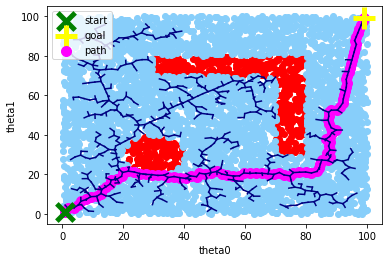

In [74]:
# Input the tree that was outputted by the RRT for visualization
visualize_rrt("""
PRINTING ENTIRE TREE _______________
NODES _______
Node 0 - Point: (1, 1), Parent: -1, Num children: 1, Child: 1, 
Node 1 - Point: (1.89041, 2.79086), Parent: 0, Num children: 2, Child: 2, 433, 
Node 2 - Point: (3.85525, 3.16422), Parent: 1, Num children: 2, Child: 3, 362, 
Node 3 - Point: (5.26434, 4.58355), Parent: 2, Num children: 2, Child: 4, 184, 
Node 4 - Point: (6.07449, 6.41211), Parent: 3, Num children: 2, Child: 5, 270, 
Node 5 - Point: (7.84221, 7.34762), Parent: 4, Num children: 2, Child: 6, 26, 
Node 6 - Point: (9.2818, 8.73599), Parent: 5, Num children: 2, Child: 7, 8, 
Node 7 - Point: (11.2743, 8.90906), Parent: 6, Num children: 2, Child: 9, 179, 
Node 8 - Point: (8.39889, 10.5306), Parent: 6, Num children: 2, Child: 27, 410, 
Node 9 - Point: (12.6696, 10.342), Parent: 7, Num children: 2, Child: 10, 140, 
Node 10 - Point: (12.8701, 12.3319), Parent: 9, Num children: 4, Child: 11, 23, 80, 421, 
Node 11 - Point: (14.2799, 13.7505), Parent: 10, Num children: 2, Child: 12, 191, 
Node 12 - Point: (15.6897, 15.1691), Parent: 11, Num children: 2, Child: 13, 145, 
Node 13 - Point: (16.0246, 17.1409), Parent: 12, Num children: 2, Child: 14, 20, 
Node 14 - Point: (17.9528, 17.672), Parent: 13, Num children: 4, Child: 15, 116, 197, 399, 
Node 15 - Point: (19.4253, 19.0254), Parent: 14, Num children: 1, Child: 16, 
Node 16 - Point: (19.7588, 20.9974), Parent: 15, Num children: 2, Child: 17, 25, 
Node 17 - Point: (21.6567, 21.6283), Parent: 16, Num children: 2, Child: 18, 21, 
Node 18 - Point: (23.6145, 21.2199), Parent: 17, Num children: 1, Child: 19, 
Node 19 - Point: (25.4484, 20.4218), Parent: 18, Num children: 2, Child: 22, 24, 
Node 20 - Point: (14.3772, 18.2748), Parent: 13, Num children: 1, Child: 302, 
Node 21 - Point: (21.9139, 23.6117), Parent: 17, Num children: 1, Child: 323, 
Node 22 - Point: (27.4043, 20.004), Parent: 19, Num children: 2, Child: 28, 531, 
Node 23 - Point: (10.8817, 12.5466), Parent: 10, Num children: 2, Child: 307, 316, 
Node 24 - Point: (25.0669, 18.4585), Parent: 19, Num children: 2, Child: 269, 352, 
Node 25 - Point: (18.6004, 22.6278), Parent: 16, Num children: 2, Child: 29, 79, 
Node 26 - Point: (7.82321, 6.99064), Parent: 5, Num children: 0, Child: 
Node 27 - Point: (7.3568, 12.2376), Parent: 8, Num children: 3, Child: 146, 154, 287, 
Node 28 - Point: (29.4005, 19.8812), Parent: 22, Num children: 2, Child: 40, 215, 
Node 29 - Point: (18.0548, 24.5519), Parent: 25, Num children: 3, Child: 30, 244, 463, 
Node 30 - Point: (18.3817, 26.525), Parent: 29, Num children: 2, Child: 31, 453, 
Node 31 - Point: (17.7939, 28.4367), Parent: 30, Num children: 3, Child: 32, 542, 632, 
Node 32 - Point: (17.7427, 30.436), Parent: 31, Num children: 2, Child: 33, 181, 
Node 33 - Point: (17.1842, 32.3564), Parent: 32, Num children: 4, Child: 34, 43, 243, 698, 
Node 34 - Point: (17.4846, 34.3337), Parent: 33, Num children: 1, Child: 35, 
Node 35 - Point: (19.0515, 35.5767), Parent: 34, Num children: 2, Child: 36, 90, 
Node 36 - Point: (20.6183, 36.8197), Parent: 35, Num children: 1, Child: 37, 
Node 37 - Point: (22.1852, 38.0627), Parent: 36, Num children: 2, Child: 38, 245, 
Node 38 - Point: (23.752, 39.3057), Parent: 37, Num children: 1, Child: 39, 
Node 39 - Point: (23.6447, 41.3028), Parent: 38, Num children: 1, Child: 41, 
Node 40 - Point: (31.3612, 19.4869), Parent: 28, Num children: 1, Child: 44, 
Node 41 - Point: (24.7582, 42.9641), Parent: 39, Num children: 2, Child: 42, 345, 
Node 42 - Point: (25.1737, 44.9205), Parent: 41, Num children: 3, Child: 45, 47, 414, 
Node 43 - Point: (15.2001, 32.608), Parent: 33, Num children: 2, Child: 55, 137, 
Node 44 - Point: (33.3556, 19.6367), Parent: 40, Num children: 2, Child: 50, 160, 
Node 45 - Point: (27.1539, 45.2008), Parent: 42, Num children: 2, Child: 46, 266, 
Node 46 - Point: (28.7548, 46.3996), Parent: 45, Num children: 3, Child: 48, 106, 373, 
Node 47 - Point: (24.4296, 46.777), Parent: 42, Num children: 2, Child: 62, 500, 
Node 48 - Point: (30.3558, 47.5984), Parent: 46, Num children: 2, Child: 49, 614, 
Node 49 - Point: (32.1414, 48.4992), Parent: 48, Num children: 3, Child: 51, 380, 603, 
Node 50 - Point: (34.7116, 18.4622), Parent: 44, Num children: 2, Child: 54, 192, 
Node 51 - Point: (33.7003, 49.7521), Parent: 49, Num children: 3, Child: 52, 277, 312, 
Node 52 - Point: (35.2971, 50.9564), Parent: 51, Num children: 1, Child: 53, 
Node 53 - Point: (34.6089, 52.8342), Parent: 52, Num children: 2, Child: 57, 108, 
Node 54 - Point: (36.6575, 18.9242), Parent: 50, Num children: 1, Child: 56, 
Node 55 - Point: (13.7993, 31.1805), Parent: 43, Num children: 1, Child: 103, 
Node 56 - Point: (38.5738, 18.3515), Parent: 54, Num children: 2, Child: 66, 216, 
Node 57 - Point: (36.2343, 53.9996), Parent: 53, Num children: 2, Child: 58, 279, 
Node 58 - Point: (37.8597, 55.1649), Parent: 57, Num children: 1, Child: 59, 
Node 59 - Point: (39.6229, 56.109), Parent: 58, Num children: 3, Child: 60, 293, 308, 
Node 60 - Point: (41.2441, 57.2801), Parent: 59, Num children: 2, Child: 61, 74, 
Node 61 - Point: (42.8654, 58.4512), Parent: 60, Num children: 3, Child: 63, 121, 404, 
Node 62 - Point: (23.3171, 48.439), Parent: 47, Num children: 1, Child: 96, 
Node 63 - Point: (44.4867, 59.6223), Parent: 61, Num children: 1, Child: 64, 
Node 64 - Point: (46.1079, 60.7934), Parent: 63, Num children: 1, Child: 65, 
Node 65 - Point: (47.8039, 61.8535), Parent: 64, Num children: 2, Child: 67, 68, 
Node 66 - Point: (40.5353, 17.961), Parent: 56, Num children: 2, Child: 70, 550, 
Node 67 - Point: (46.7687, 63.5648), Parent: 65, Num children: 2, Child: 100, 680, 
Node 68 - Point: (49.5523, 62.8245), Parent: 65, Num children: 2, Child: 69, 97, 
Node 69 - Point: (51.1665, 64.0054), Parent: 68, Num children: 2, Child: 71, 299, 
Node 70 - Point: (42.0782, 19.2335), Parent: 66, Num children: 2, Child: 72, 180, 
Node 71 - Point: (52.8907, 65.0189), Parent: 69, Num children: 2, Child: 73, 392, 
Node 72 - Point: (44.043, 18.8596), Parent: 70, Num children: 1, Child: 75, 
Node 73 - Point: (54.5007, 66.2054), Parent: 71, Num children: 1, Child: 76, 
Node 74 - Point: (42.4261, 55.6667), Parent: 60, Num children: 1, Child: 166, 
Node 75 - Point: (44.9962, 20.6178), Parent: 72, Num children: 1, Child: 77, 
Node 76 - Point: (56.1107, 67.3919), Parent: 73, Num children: 2, Child: 78, 81, 
Node 77 - Point: (46.9402, 20.1478), Parent: 75, Num children: 2, Child: 85, 98, 
Node 78 - Point: (55.339, 69.237), Parent: 76, Num children: 0, Child: 
Node 79 - Point: (17.8208, 22.1966), Parent: 25, Num children: 1, Child: 221, 
Node 80 - Point: (12.1259, 13.8238), Parent: 10, Num children: 0, Child: 
Node 81 - Point: (58.0888, 67.0968), Parent: 76, Num children: 3, Child: 82, 138, 479, 
Node 82 - Point: (59.6987, 65.9101), Parent: 81, Num children: 2, Child: 83, 89, 
Node 83 - Point: (61.2286, 67.1982), Parent: 82, Num children: 2, Child: 84, 549, 
Node 84 - Point: (62.7585, 68.4863), Parent: 83, Num children: 2, Child: 86, 240, 
Node 85 - Point: (48.7896, 20.9092), Parent: 77, Num children: 3, Child: 91, 143, 546, 
Node 86 - Point: (64.2885, 69.7745), Parent: 84, Num children: 1, Child: 87, 
Node 87 - Point: (66.1508, 69.0453), Parent: 86, Num children: 1, Child: 88, 
Node 88 - Point: (67.0365, 67.2521), Parent: 87, Num children: 2, Child: 93, 251, 
Node 89 - Point: (60.0963, 63.95), Parent: 82, Num children: 2, Child: 111, 119, 
Node 90 - Point: (17.6448, 36.9984), Parent: 35, Num children: 1, Child: 117, 
Node 91 - Point: (50.7077, 21.4756), Parent: 85, Num children: 3, Child: 92, 284, 406, 
Node 92 - Point: (52.2893, 20.2513), Parent: 91, Num children: 1, Child: 94, 
Node 93 - Point: (69.024, 67.4746), Parent: 88, Num children: 2, Child: 387, 536, 
Node 94 - Point: (54.1956, 19.6465), Parent: 92, Num children: 2, Child: 95, 505, 
Node 95 - Point: (56.1393, 19.1753), Parent: 94, Num children: 3, Child: 105, 114, 149, 
Node 96 - Point: (21.8473, 49.7953), Parent: 62, Num children: 3, Child: 101, 471, 604, 
Node 97 - Point: (50.9909, 61.4351), Parent: 68, Num children: 2, Child: 99, 158, 
Node 98 - Point: (47.3827, 18.1974), Parent: 77, Num children: 1, Child: 120, 
Node 99 - Point: (52.5747, 61.8925), Parent: 97, Num children: 1, Child: 134, 
Node 100 - Point: (45.2295, 64.8418), Parent: 67, Num children: 3, Child: 102, 211, 292, 
Node 101 - Point: (19.9493, 49.1648), Parent: 96, Num children: 1, Child: 104, 
Node 102 - Point: (44.1408, 66.5195), Parent: 100, Num children: 1, Child: 129, 
Node 103 - Point: (12.0354, 30.2378), Parent: 55, Num children: 2, Child: 171, 205, 
Node 104 - Point: (19.0684, 50.9603), Parent: 101, Num children: 2, Child: 107, 416, 
Node 105 - Point: (58.1364, 19.284), Parent: 95, Num children: 1, Child: 109, 
Node 106 - Point: (30.1226, 44.9405), Parent: 46, Num children: 1, Child: 112, 
Node 107 - Point: (17.8332, 52.5333), Parent: 104, Num children: 3, Child: 110, 113, 623, 
Node 108 - Point: (33.4554, 54.4681), Parent: 53, Num children: 3, Child: 130, 176, 389, 
Node 109 - Point: (59.5347, 20.7139), Parent: 105, Num children: 2, Child: 115, 128, 
Node 110 - Point: (15.8351, 52.6217), Parent: 107, Num children: 1, Child: 193, 
Node 111 - Point: (61.8447, 64.2692), Parent: 89, Num children: 1, Child: 122, 
Node 112 - Point: (31.6263, 43.6217), Parent: 106, Num children: 1, Child: 133, 
Node 113 - Point: (18.0306, 54.5235), Parent: 107, Num children: 2, Child: 123, 369, 
Node 114 - Point: (56.2068, 17.1765), Parent: 95, Num children: 3, Child: 168, 300, 436, 
Node 115 - Point: (61.525, 20.5167), Parent: 109, Num children: 2, Child: 118, 259, 
Node 116 - Point: (18.6035, 15.7808), Parent: 14, Num children: 1, Child: 455, 
Node 117 - Point: (18.6708, 38.7152), Parent: 90, Num children: 1, Child: 126, 
Node 118 - Point: (63.5173, 20.6922), Parent: 115, Num children: 2, Child: 131, 478, 
Node 119 - Point: (58.9157, 63.7771), Parent: 89, Num children: 1, Child: 672, 
Node 120 - Point: (47.0564, 16.6955), Parent: 98, Num children: 1, Child: 124, 
Node 121 - Point: (41.8507, 60.1747), Parent: 61, Num children: 2, Child: 125, 273, 
Node 122 - Point: (62.3493, 62.334), Parent: 111, Num children: 2, Child: 162, 641, 
Node 123 - Point: (16.6557, 55.9761), Parent: 113, Num children: 2, Child: 127, 136, 
Node 124 - Point: (47.6932, 14.7995), Parent: 120, Num children: 1, Child: 159, 
Node 125 - Point: (40.4789, 61.63), Parent: 121, Num children: 1, Child: 135, 
Node 126 - Point: (16.9609, 39.7527), Parent: 117, Num children: 2, Child: 276, 397, 
Node 127 - Point: (15.2823, 57.43), Parent: 123, Num children: 3, Child: 139, 144, 272, 
Node 128 - Point: (59.728, 22.2602), Parent: 109, Num children: 0, Child: 
Node 129 - Point: (44.1101, 68.5192), Parent: 102, Num children: 2, Child: 132, 265, 
Node 130 - Point: (33.3569, 53.6743), Parent: 108, Num children: 1, Child: 503, 
Node 131 - Point: (65.5124, 20.5531), Parent: 118, Num children: 2, Child: 141, 408, 
Node 132 - Point: (42.2638, 69.2881), Parent: 129, Num children: 1, Child: 338, 
Node 133 - Point: (32.4628, 41.8051), Parent: 112, Num children: 2, Child: 164, 295, 
Node 134 - Point: (54.5621, 62.117), Parent: 99, Num children: 1, Child: 628, 
Node 135 - Point: (38.9482, 62.9173), Parent: 125, Num children: 1, Child: 165, 
Node 136 - Point: (18.0282, 57.4309), Parent: 123, Num children: 1, Child: 157, 
Node 137 - Point: (13.8709, 34.1025), Parent: 43, Num children: 1, Child: 147, 
Node 138 - Point: (59.2692, 67.6554), Parent: 81, Num children: 0, Child: 
Node 139 - Point: (13.3025, 57.147), Parent: 127, Num children: 1, Child: 150, 
Node 140 - Point: (14.2857, 9.16383), Parent: 9, Num children: 1, Child: 261, 
Node 141 - Point: (67.4989, 20.3212), Parent: 131, Num children: 2, Child: 142, 151, 
Node 142 - Point: (69.4723, 19.9962), Parent: 141, Num children: 2, Child: 153, 206, 
Node 143 - Point: (48.4177, 22.8744), Parent: 85, Num children: 2, Child: 148, 638, 
Node 144 - Point: (15.0741, 59.4191), Parent: 127, Num children: 2, Child: 155, 355, 
Node 145 - Point: (16.9129, 13.5867), Parent: 12, Num children: 0, Child: 
Node 146 - Point: (5.67532, 13.3205), Parent: 27, Num children: 1, Child: 364, 
Node 147 - Point: (12.289, 35.3262), Parent: 137, Num children: 2, Child: 337, 365, 
Node 148 - Point: (47.2295, 24.4831), Parent: 143, Num children: 1, Child: 161, 
Node 149 - Point: (56.6165, 19.0709), Parent: 95, Num children: 0, Child: 
Node 150 - Point: (11.508, 56.2638), Parent: 139, Num children: 1, Child: 217, 
Node 151 - Point: (67.8899, 22.2826), Parent: 141, Num children: 2, Child: 152, 339, 
Node 152 - Point: (67.3663, 24.2129), Parent: 151, Num children: 2, Child: 200, 668, 
Node 153 - Point: (71.2326, 20.9456), Parent: 142, Num children: 1, Child: 167, 
Node 154 - Point: (5.97018, 10.7963), Parent: 27, Num children: 0, Child: 
Node 155 - Point: (14.4753, 61.3274), Parent: 144, Num children: 1, Child: 156, 
Node 156 - Point: (13.9281, 63.251), Parent: 155, Num children: 2, Child: 170, 234, 
Node 157 - Point: (20.0013, 57.7577), Parent: 136, Num children: 1, Child: 163, 
Node 158 - Point: (51.9102, 59.6589), Parent: 97, Num children: 2, Child: 189, 692, 
Node 159 - Point: (48.5384, 12.9869), Parent: 124, Num children: 2, Child: 356, 441, 
Node 160 - Point: (34.7546, 20.5714), Parent: 44, Num children: 0, Child: 
Node 161 - Point: (45.7237, 25.7994), Parent: 148, Num children: 3, Child: 202, 213, 591, 
Node 162 - Point: (62.5881, 60.3483), Parent: 122, Num children: 1, Child: 188, 
Node 163 - Point: (20.9626, 59.5115), Parent: 157, Num children: 2, Child: 178, 314, 
Node 164 - Point: (33.0942, 39.9073), Parent: 133, Num children: 1, Child: 187, 
Node 165 - Point: (37.4008, 64.1843), Parent: 135, Num children: 2, Child: 198, 253, 
Node 166 - Point: (43.7899, 54.2038), Parent: 74, Num children: 2, Child: 175, 212, 
Node 167 - Point: (72.8044, 19.7089), Parent: 153, Num children: 1, Child: 169, 
Node 168 - Point: (57.2646, 15.4791), Parent: 114, Num children: 1, Child: 199, 
Node 169 - Point: (74.7568, 19.2749), Parent: 167, Num children: 2, Child: 173, 174, 
Node 170 - Point: (13.3953, 65.1788), Parent: 156, Num children: 1, Child: 172, 
Node 171 - Point: (10.9031, 28.5891), Parent: 103, Num children: 1, Child: 358, 
Node 172 - Point: (12.6369, 67.0294), Parent: 170, Num children: 2, Child: 177, 182, 
Node 173 - Point: (75.0309, 17.2938), Parent: 169, Num children: 1, Child: 195, 
Node 174 - Point: (75.8546, 20.9467), Parent: 169, Num children: 2, Child: 186, 413, 
Node 175 - Point: (44.1307, 52.233), Parent: 166, Num children: 1, Child: 204, 
Node 176 - Point: (33.0832, 56.4332), Parent: 108, Num children: 0, Child: 
Node 177 - Point: (12.5238, 69.0262), Parent: 172, Num children: 3, Child: 183, 257, 378, 
Node 178 - Point: (20.9964, 61.5112), Parent: 163, Num children: 0, Child: 
Node 179 - Point: (11.6359, 6.94202), Parent: 7, Num children: 1, Child: 246, 
Node 180 - Point: (40.5881, 20.5675), Parent: 70, Num children: 0, Child: 
Node 181 - Point: (16.0162, 30.8247), Parent: 32, Num children: 0, Child: 
Node 182 - Point: (10.665, 66.695), Parent: 172, Num children: 1, Child: 330, 
Node 183 - Point: (11.6937, 70.8458), Parent: 177, Num children: 2, Child: 185, 449, 
Node 184 - Point: (6.2674, 4.71826), Parent: 3, Num children: 1, Child: 333, 
Node 185 - Point: (12.2229, 72.7745), Parent: 183, Num children: 2, Child: 190, 229, 
Node 186 - Point: (77.8489, 21.0967), Parent: 174, Num children: 1, Child: 194, 
Node 187 - Point: (34.9529, 39.1689), Parent: 164, Num children: 1, Child: 401, 
Node 188 - Point: (62.8003, 58.3596), Parent: 162, Num children: 2, Child: 209, 655, 
Node 189 - Point: (50.5408, 58.2013), Parent: 158, Num children: 3, Child: 247, 499, 599, 
Node 190 - Point: (10.3094, 73.3563), Parent: 185, Num children: 1, Child: 201, 
Node 191 - Point: (13.9001, 14.3942), Parent: 11, Num children: 0, Child: 
Node 192 - Point: (33.9189, 16.6261), Parent: 50, Num children: 1, Child: 196, 
Node 193 - Point: (14.2943, 51.3466), Parent: 110, Num children: 2, Child: 267, 606, 
Node 194 - Point: (79.8447, 21.2264), Parent: 186, Num children: 1, Child: 227, 
Node 195 - Point: (75.3452, 15.3186), Parent: 173, Num children: 1, Child: 207, 
Node 196 - Point: (32.8732, 14.9212), Parent: 192, Num children: 1, Child: 203, 
Node 197 - Point: (17.2722, 17.8987), Parent: 14, Num children: 1, Child: 236, 
Node 198 - Point: (37.871, 64.7522), Parent: 165, Num children: 1, Child: 502, 
Node 199 - Point: (58.4011, 13.8334), Parent: 168, Num children: 2, Child: 222, 278, 
Node 200 - Point: (68.2398, 26.012), Parent: 152, Num children: 2, Child: 237, 607, 
Node 201 - Point: (9.90301, 75.3146), Parent: 190, Num children: 3, Child: 208, 255, 558, 
Node 202 - Point: (46.4953, 27.6446), Parent: 161, Num children: 2, Child: 214, 555, 
Node 203 - Point: (31.3412, 13.6355), Parent: 196, Num children: 1, Child: 232, 
Node 204 - Point: (45.5889, 50.8643), Parent: 175, Num children: 2, Child: 223, 297, 
Node 205 - Point: (13.3388, 29.3171), Parent: 103, Num children: 0, Child: 
Node 206 - Point: (68.9097, 18.077), Parent: 142, Num children: 1, Child: 349, 
Node 207 - Point: (76.2916, 13.5567), Parent: 195, Num children: 2, Child: 219, 427, 
Node 208 - Point: (10.7222, 77.1391), Parent: 201, Num children: 2, Child: 210, 602, 
Node 209 - Point: (63.4422, 56.4654), Parent: 188, Num children: 2, Child: 230, 651, 
Node 210 - Point: (12.3054, 78.3612), Parent: 208, Num children: 1, Child: 218, 
Node 211 - Point: (45.724, 64.0368), Parent: 100, Num children: 0, Child: 
Node 212 - Point: (45.7882, 54.1228), Parent: 166, Num children: 1, Child: 306, 
Node 213 - Point: (44.6855, 24.09), Parent: 161, Num children: 2, Child: 360, 635, 
Node 214 - Point: (45.4989, 29.3787), Parent: 202, Num children: 3, Child: 225, 249, 375, 
Node 215 - Point: (28.4768, 18.1073), Parent: 28, Num children: 2, Child: 231, 573, 
Node 216 - Point: (38.5998, 16.3517), Parent: 56, Num children: 1, Child: 350, 
Node 217 - Point: (10.9167, 58.1744), Parent: 150, Num children: 2, Child: 390, 553, 
Node 218 - Point: (11.9861, 80.3356), Parent: 210, Num children: 2, Child: 235, 520, 
Node 219 - Point: (78.2363, 13.0896), Parent: 207, Num children: 2, Child: 220, 329, 
Node 220 - Point: (79.8147, 11.8613), Parent: 219, Num children: 2, Child: 226, 367, 
Node 221 - Point: (18.3801, 21.9853), Parent: 79, Num children: 0, Child: 
Node 222 - Point: (59.4294, 12.1179), Parent: 199, Num children: 1, Child: 224, 
Node 223 - Point: (44.2015, 49.4238), Parent: 204, Num children: 1, Child: 480, 
Node 224 - Point: (61.1162, 11.0434), Parent: 222, Num children: 3, Child: 239, 510, 625, 
Node 225 - Point: (45.9331, 31.331), Parent: 214, Num children: 2, Child: 238, 395, 
Node 226 - Point: (81.7981, 11.6045), Parent: 220, Num children: 2, Child: 228, 405, 
Node 227 - Point: (81.7777, 20.713), Parent: 194, Num children: 1, Child: 241, 
Node 228 - Point: (83.7436, 11.1407), Parent: 226, Num children: 2, Child: 233, 353, 
Node 229 - Point: (14.2008, 73.071), Parent: 185, Num children: 2, Child: 285, 574, 
Node 230 - Point: (63.4936, 54.466), Parent: 209, Num children: 1, Child: 242, 
Node 231 - Point: (29.1057, 18.6029), Parent: 215, Num children: 0, Child: 
Node 232 - Point: (32.264, 11.8611), Parent: 203, Num children: 2, Child: 311, 430, 
Node 233 - Point: (84.6693, 9.36783), Parent: 228, Num children: 2, Child: 264, 281, 
Node 234 - Point: (15.8969, 63.6029), Parent: 156, Num children: 1, Child: 341, 
Node 235 - Point: (13.6131, 81.4987), Parent: 218, Num children: 2, Child: 254, 450, 
Node 236 - Point: (17.4136, 18.7693), Parent: 197, Num children: 0, Child: 
Node 237 - Point: (67.3319, 27.794), Parent: 200, Num children: 1, Child: 252, 
Node 238 - Point: (47.2598, 32.8275), Parent: 225, Num children: 1, Child: 286, 
Node 239 - Point: (62.4518, 9.55471), Parent: 224, Num children: 2, Child: 457, 508, 
Node 240 - Point: (61.947, 69.3692), Parent: 84, Num children: 0, Child: 
Node 241 - Point: (83.607, 21.5215), Parent: 227, Num children: 1, Child: 256, 
Node 242 - Point: (64.979, 53.1269), Parent: 230, Num children: 2, Child: 248, 357, 
Node 243 - Point: (17.6656, 32.5177), Parent: 33, Num children: 0, Child: 
Node 244 - Point: (18.2003, 24.3528), Parent: 29, Num children: 0, Child: 
Node 245 - Point: (21.2269, 38.5282), Parent: 37, Num children: 0, Child: 
Node 246 - Point: (12.0962, 4.99571), Parent: 179, Num children: 1, Child: 425, 
Node 247 - Point: (51.3332, 56.365), Parent: 189, Num children: 2, Child: 303, 426, 
Node 248 - Point: (66.6889, 52.0893), Parent: 242, Num children: 2, Child: 250, 464, 
Node 249 - Point: (45.8269, 30.258), Parent: 214, Num children: 1, Child: 578, 
Node 250 - Point: (68.688, 52.0315), Parent: 248, Num children: 2, Child: 280, 583, 
Node 251 - Point: (66.0165, 65.5317), Parent: 88, Num children: 3, Child: 429, 543, 631, 
Node 252 - Point: (68.8251, 29.1246), Parent: 237, Num children: 3, Child: 260, 438, 611, 
Node 253 - Point: (35.4108, 63.9841), Parent: 165, Num children: 2, Child: 315, 465, 
Node 254 - Point: (13.0943, 83.4303), Parent: 235, Num children: 2, Child: 263, 331, 
Node 255 - Point: (8.19702, 76.3584), Parent: 201, Num children: 2, Child: 258, 575, 
Node 256 - Point: (84.3738, 23.3686), Parent: 241, Num children: 2, Child: 262, 328, 
Node 257 - Point: (13.8657, 70.5092), Parent: 177, Num children: 0, Child: 
Node 258 - Point: (6.5965, 77.5577), Parent: 255, Num children: 1, Child: 442, 
Node 259 - Point: (61.5894, 21.1786), Parent: 115, Num children: 0, Child: 
Node 260 - Point: (70.6934, 29.8382), Parent: 252, Num children: 1, Child: 498, 
Node 261 - Point: (15.4141, 9.01297), Parent: 140, Num children: 2, Child: 282, 372, 
Node 262 - Point: (84.7213, 25.3382), Parent: 256, Num children: 1, Child: 268, 
Node 263 - Point: (14.0357, 85.1949), Parent: 254, Num children: 3, Child: 283, 298, 382, 
Node 264 - Point: (86.5626, 10.0124), Parent: 233, Num children: 1, Child: 304, 
Node 265 - Point: (45.7165, 69.7105), Parent: 129, Num children: 1, Child: 288, 
Node 266 - Point: (26.7134, 43.474), Parent: 45, Num children: 0, Child: 
Node 267 - Point: (12.6742, 50.174), Parent: 193, Num children: 2, Child: 335, 700, 
Node 268 - Point: (85.1841, 27.2839), Parent: 262, Num children: 2, Child: 271, 525, 
Node 269 - Point: (24.6476, 19.4948), Parent: 24, Num children: 0, Child: 
Node 270 - Point: (6.04589, 8.2577), Parent: 4, Num children: 0, Child: 
Node 271 - Point: (87.1701, 27.0481), Parent: 268, Num children: 2, Child: 274, 301, 
Node 272 - Point: (14.4468, 56.4252), Parent: 127, Num children: 1, Child: 454, 
Node 273 - Point: (41.1551, 59.9291), Parent: 121, Num children: 0, Child: 
Node 274 - Point: (87.9842, 28.875), Parent: 271, Num children: 2, Child: 275, 456, 
Node 275 - Point: (86.9674, 30.5972), Parent: 274, Num children: 3, Child: 332, 444, 562, 
Node 276 - Point: (15.3443, 38.5752), Parent: 126, Num children: 0, Child: 
Node 277 - Point: (34.0321, 50.7617), Parent: 51, Num children: 0, Child: 
Node 278 - Point: (56.975, 12.4311), Parent: 199, Num children: 1, Child: 477, 
Node 279 - Point: (35.5369, 55.8645), Parent: 57, Num children: 0, Child: 
Node 280 - Point: (69.8667, 50.4157), Parent: 250, Num children: 1, Child: 383, 
Node 281 - Point: (84.231, 7.41646), Parent: 233, Num children: 1, Child: 294, 
Node 282 - Point: (16.6587, 7.44735), Parent: 261, Num children: 1, Child: 344, 
Node 283 - Point: (12.786, 86.7564), Parent: 263, Num children: 1, Child: 334, 
Node 284 - Point: (52.0438, 22.9638), Parent: 91, Num children: 1, Child: 448, 
Node 285 - Point: (16.1916, 73.2627), Parent: 229, Num children: 1, Child: 296, 
Node 286 - Point: (48.6698, 34.246), Parent: 238, Num children: 1, Child: 289, 
Node 287 - Point: (8.43902, 13.3548), Parent: 27, Num children: 0, Child: 
Node 288 - Point: (45.9365, 69.1745), Parent: 265, Num children: 0, Child: 
Node 289 - Point: (49.8792, 35.8389), Parent: 286, Num children: 1, Child: 290, 
Node 290 - Point: (50.6636, 37.6787), Parent: 289, Num children: 3, Child: 291, 402, 528, 
Node 291 - Point: (52.4993, 38.4726), Parent: 290, Num children: 2, Child: 309, 596, 
Node 292 - Point: (44.5235, 64.7672), Parent: 100, Num children: 0, Child: 
Node 293 - Point: (38.7466, 56.8379), Parent: 59, Num children: 1, Child: 384, 
Node 294 - Point: (82.6333, 6.2134), Parent: 281, Num children: 2, Child: 313, 368, 
Node 295 - Point: (32.9342, 42.9613), Parent: 133, Num children: 1, Child: 343, 
Node 296 - Point: (18.1657, 72.9419), Parent: 285, Num children: 1, Child: 310, 
Node 297 - Point: (47.5541, 50.4924), Parent: 204, Num children: 1, Child: 321, 
Node 298 - Point: (15.6357, 86.3948), Parent: 263, Num children: 2, Child: 305, 347, 
Node 299 - Point: (50.8369, 63.5246), Parent: 69, Num children: 0, Child: 
Node 300 - Point: (54.4885, 17.483), Parent: 114, Num children: 0, Child: 
Node 301 - Point: (88.7863, 25.8699), Parent: 271, Num children: 1, Child: 320, 
Node 302 - Point: (14.4084, 20.2746), Parent: 20, Num children: 1, Child: 440, 
Node 303 - Point: (53.2411, 55.765), Parent: 247, Num children: 1, Child: 434, 
Node 304 - Point: (88.4673, 9.40245), Parent: 264, Num children: 2, Child: 359, 663, 
Node 305 - Point: (17.3026, 87.5), Parent: 298, Num children: 2, Child: 322, 568, 
Node 306 - Point: (47.2819, 52.7928), Parent: 212, Num children: 0, Child: 
Node 307 - Point: (10.9087, 12.3969), Parent: 23, Num children: 0, Child: 
Node 308 - Point: (39.0289, 55.8524), Parent: 59, Num children: 1, Child: 376, 
Node 309 - Point: (54.3373, 37.6842), Parent: 291, Num children: 3, Child: 317, 422, 534, 
Node 310 - Point: (19.1158, 74.7018), Parent: 296, Num children: 1, Child: 318, 
Node 311 - Point: (32.3615, 9.8635), Parent: 232, Num children: 2, Child: 481, 490, 
Node 312 - Point: (35.1836, 48.4106), Parent: 51, Num children: 0, Child: 
Node 313 - Point: (80.6551, 5.91891), Parent: 294, Num children: 1, Child: 324, 
Node 314 - Point: (22.5196, 58.2562), Parent: 163, Num children: 1, Child: 398, 
Node 315 - Point: (34.9453, 65.9292), Parent: 253, Num children: 1, Child: 570, 
Node 316 - Point: (10.2443, 14.3224), Parent: 23, Num children: 1, Child: 417, 
Node 317 - Point: (55.5343, 36.082), Parent: 309, Num children: 1, Child: 325, 
Node 318 - Point: (20.8748, 75.6536), Parent: 310, Num children: 2, Child: 319, 622, 
Node 319 - Point: (22.8187, 76.124), Parent: 318, Num children: 2, Child: 458, 483, 
Node 320 - Point: (90.1327, 27.3488), Parent: 301, Num children: 2, Child: 327, 340, 
Node 321 - Point: (49.5275, 50.1675), Parent: 297, Num children: 1, Child: 547, 
Node 322 - Point: (18.5754, 89.0427), Parent: 305, Num children: 1, Child: 326, 
Node 323 - Point: (21.5066, 23.5245), Parent: 21, Num children: 0, Child: 
Node 324 - Point: (78.6986, 5.50392), Parent: 313, Num children: 1, Child: 381, 
Node 325 - Point: (57.4855, 36.5211), Parent: 317, Num children: 1, Child: 361, 
Node 326 - Point: (20.5752, 89.0714), Parent: 322, Num children: 3, Child: 336, 420, 535, 
Node 327 - Point: (92.0235, 26.697), Parent: 320, Num children: 2, Child: 351, 403, 
Node 328 - Point: (84.3894, 22.6811), Parent: 256, Num children: 0, Child: 
Node 329 - Point: (78.5704, 15.0615), Parent: 219, Num children: 1, Child: 423, 
Node 330 - Point: (8.69716, 66.3379), Parent: 182, Num children: 1, Child: 488, 
Node 331 - Point: (11.0949, 83.4769), Parent: 254, Num children: 0, Child: 
Node 332 - Point: (87.8323, 32.4005), Parent: 275, Num children: 2, Child: 348, 618, 
Node 333 - Point: (7.24423, 2.97304), Parent: 184, Num children: 1, Child: 459, 
Node 334 - Point: (11.1054, 87.8407), Parent: 283, Num children: 2, Child: 346, 363, 
Node 335 - Point: (10.6867, 50.3969), Parent: 267, Num children: 2, Child: 409, 586, 
Node 336 - Point: (22.4709, 89.7088), Parent: 326, Num children: 2, Child: 342, 354, 
Node 337 - Point: (10.8043, 36.6663), Parent: 147, Num children: 1, Child: 370, 
Node 338 - Point: (40.3253, 68.7958), Parent: 132, Num children: 0, Child: 
Node 339 - Point: (68.017, 23.0677), Parent: 151, Num children: 0, Child: 
Node 340 - Point: (89.2815, 26.8084), Parent: 320, Num children: 0, Child: 
Node 341 - Point: (16.0052, 65.6), Parent: 234, Num children: 0, Child: 
Node 342 - Point: (24.3088, 90.4975), Parent: 336, Num children: 2, Child: 366, 588, 
Node 343 - Point: (33.3832, 43.7942), Parent: 295, Num children: 0, Child: 
Node 344 - Point: (17.8314, 6.01557), Parent: 282, Num children: 1, Child: 407, 
Node 345 - Point: (25.6583, 41.7489), Parent: 41, Num children: 1, Child: 391, 
Node 346 - Point: (9.40248, 88.8895), Parent: 334, Num children: 1, Child: 400, 
Node 347 - Point: (16.9143, 84.8568), Parent: 298, Num children: 0, Child: 
Node 348 - Point: (87.4268, 34.359), Parent: 332, Num children: 1, Child: 377, 
Node 349 - Point: (67.3427, 16.8343), Parent: 206, Num children: 0, Child: 
Node 350 - Point: (39.3517, 14.4984), Parent: 216, Num children: 1, Child: 551, 
Node 351 - Point: (93.8436, 27.5261), Parent: 327, Num children: 1, Child: 470, 
Node 352 - Point: (25.2101, 16.4637), Parent: 24, Num children: 3, Child: 396, 411, 415, 
Node 353 - Point: (82.7056, 10.1446), Parent: 228, Num children: 1, Child: 657, 
Node 354 - Point: (23.4441, 89.6618), Parent: 336, Num children: 1, Child: 554, 
Node 355 - Point: (15.3923, 59.5963), Parent: 144, Num children: 0, Child: 
Node 356 - Point: (48.0384, 11.0504), Parent: 159, Num children: 1, Child: 386, 
Node 357 - Point: (63.714, 51.5778), Parent: 242, Num children: 2, Child: 476, 489, 
Node 358 - Point: (9.01414, 27.9321), Parent: 171, Num children: 1, Child: 371, 
Node 359 - Point: (89.0654, 7.49397), Parent: 304, Num children: 1, Child: 388, 
Node 360 - Point: (45.7171, 24.3905), Parent: 213, Num children: 0, Child: 
Node 361 - Point: (57.8522, 34.555), Parent: 325, Num children: 1, Child: 432, 
Node 362 - Point: (3.50138, 3.7932), Parent: 2, Num children: 0, Child: 
Node 363 - Point: (11.8666, 89.6901), Parent: 334, Num children: 2, Child: 445, 473, 
Node 364 - Point: (4.87385, 12.0243), Parent: 146, Num children: 1, Child: 563, 
Node 365 - Point: (11.4216, 33.9732), Parent: 147, Num children: 0, Child: 
Node 366 - Point: (25.9878, 91.5842), Parent: 342, Num children: 2, Child: 437, 524, 
Node 367 - Point: (79.4861, 9.88844), Parent: 220, Num children: 1, Child: 374, 
Node 368 - Point: (83.2503, 4.31094), Parent: 294, Num children: 0, Child: 
Node 369 - Point: (18.5365, 55.3925), Parent: 113, Num children: 0, Child: 
Node 370 - Point: (11.0932, 38.6453), Parent: 337, Num children: 1, Child: 412, 
Node 371 - Point: (7.56249, 28.508), Parent: 358, Num children: 1, Child: 418, 
Node 372 - Point: (17.0819, 10.0276), Parent: 261, Num children: 1, Child: 565, 
Node 373 - Point: (29.2555, 46.1706), Parent: 46, Num children: 0, Child: 
Node 374 - Point: (77.4931, 10.0549), Parent: 367, Num children: 1, Child: 379, 
Node 375 - Point: (46.0309, 28.6074), Parent: 214, Num children: 0, Child: 
Node 376 - Point: (39.6938, 53.9661), Parent: 308, Num children: 0, Child: 
Node 377 - Point: (87.8578, 36.312), Parent: 348, Num children: 1, Child: 385, 
Node 378 - Point: (12.0834, 68.8576), Parent: 177, Num children: 0, Child: 
Node 379 - Point: (77.2644, 9.37877), Parent: 374, Num children: 0, Child: 
Node 380 - Point: (33.0436, 48.4919), Parent: 49, Num children: 0, Child: 
Node 381 - Point: (77.0099, 4.43225), Parent: 324, Num children: 1, Child: 394, 
Node 382 - Point: (14.7062, 84.9692), Parent: 263, Num children: 1, Child: 556, 
Node 383 - Point: (69.7626, 48.4184), Parent: 280, Num children: 1, Child: 451, 
Node 384 - Point: (38.4339, 58.8133), Parent: 293, Num children: 0, Child: 
Node 385 - Point: (86.4007, 37.682), Parent: 377, Num children: 3, Child: 393, 462, 494, 
Node 386 - Point: (48.9152, 9.25285), Parent: 356, Num children: 2, Child: 443, 516, 
Node 387 - Point: (69.9921, 69.2247), Parent: 93, Num children: 0, Child: 
Node 388 - Point: (90.2218, 5.86218), Parent: 359, Num children: 2, Child: 419, 511, 
Node 389 - Point: (33.3894, 54.9261), Parent: 108, Num children: 0, Child: 
Node 390 - Point: (9.00327, 57.5922), Parent: 217, Num children: 1, Child: 447, 
Node 391 - Point: (26.7578, 40.5089), Parent: 345, Num children: 0, Child: 
Node 392 - Point: (52.2328, 66.9076), Parent: 71, Num children: 0, Child: 
Node 393 - Point: (87.7411, 39.1664), Parent: 385, Num children: 1, Child: 435, 
Node 394 - Point: (75.0164, 4.27226), Parent: 381, Num children: 1, Child: 532, 
Node 395 - Point: (44.8881, 32.5518), Parent: 225, Num children: 0, Child: 
Node 396 - Point: (23.8873, 15.8316), Parent: 352, Num children: 1, Child: 491, 
Node 397 - Point: (16.9707, 41.7527), Parent: 126, Num children: 1, Child: 496, 
Node 398 - Point: (23.5111, 56.5193), Parent: 314, Num children: 1, Child: 509, 
Node 399 - Point: (17.4222, 17.0368), Parent: 14, Num children: 0, Child: 
Node 400 - Point: (7.42083, 89.1598), Parent: 346, Num children: 2, Child: 424, 560, 
Node 401 - Point: (36.7788, 39.985), Parent: 187, Num children: 1, Child: 493, 
Node 402 - Point: (48.8727, 38.5689), Parent: 290, Num children: 1, Child: 569, 
Node 403 - Point: (92.9202, 24.9093), Parent: 327, Num children: 1, Child: 431, 
Node 404 - Point: (42.6904, 59.0753), Parent: 61, Num children: 0, Child: 
Node 405 - Point: (82.0991, 13.5817), Parent: 226, Num children: 1, Child: 428, 
Node 406 - Point: (50.7775, 19.9617), Parent: 91, Num children: 0, Child: 
Node 407 - Point: (19.7955, 5.6384), Parent: 344, Num children: 0, Child: 
Node 408 - Point: (65.69, 19.5336), Parent: 131, Num children: 0, Child: 
Node 409 - Point: (8.80511, 49.7189), Parent: 335, Num children: 2, Child: 492, 642, 
Node 410 - Point: (7.40577, 11.0427), Parent: 8, Num children: 1, Child: 552, 
Node 411 - Point: (25.3276, 15.8015), Parent: 352, Num children: 1, Child: 683, 
Node 412 - Point: (12.5194, 40.0474), Parent: 370, Num children: 1, Child: 522, 
Node 413 - Point: (74.6075, 22.4164), Parent: 174, Num children: 0, Child: 
Node 414 - Point: (23.8225, 45.0117), Parent: 42, Num children: 0, Child: 
Node 415 - Point: (24.0937, 17.3373), Parent: 352, Num children: 0, Child: 
Node 416 - Point: (19.2734, 50.0707), Parent: 104, Num children: 0, Child: 
Node 417 - Point: (9.44617, 16.1563), Parent: 316, Num children: 1, Child: 469, 
Node 418 - Point: (5.97333, 29.7223), Parent: 371, Num children: 2, Child: 538, 571, 
Node 419 - Point: (88.7964, 5.29768), Parent: 388, Num children: 1, Child: 612, 
Node 420 - Point: (19.92, 88.3299), Parent: 326, Num children: 0, Child: 
Node 421 - Point: (11.9679, 12.4236), Parent: 10, Num children: 0, Child: 
Node 422 - Point: (53.0792, 36.1295), Parent: 309, Num children: 0, Child: 
Node 423 - Point: (77.5665, 15.261), Parent: 329, Num children: 0, Child: 
Node 424 - Point: (7.60845, 91.151), Parent: 400, Num children: 0, Child: 
Node 425 - Point: (13.3648, 3.44955), Parent: 246, Num children: 0, Child: 
Node 426 - Point: (50.4956, 56.5681), Parent: 247, Num children: 0, Child: 
Node 427 - Point: (74.3601, 13.038), Parent: 207, Num children: 0, Child: 
Node 428 - Point: (80.3434, 13.8667), Parent: 405, Num children: 0, Child: 
Node 429 - Point: (65.0077, 66.7559), Parent: 251, Num children: 1, Child: 636, 
Node 430 - Point: (30.2916, 11.5302), Parent: 232, Num children: 0, Child: 
Node 431 - Point: (94.3655, 23.5269), Parent: 403, Num children: 2, Child: 512, 557, 
Node 432 - Point: (56.1198, 33.5555), Parent: 361, Num children: 1, Child: 523, 
Node 433 - Point: (0.886502, 4.52065), Parent: 1, Num children: 0, Child: 
Node 434 - Point: (52.1834, 55.4889), Parent: 303, Num children: 0, Child: 
Node 435 - Point: (88.5163, 41.0101), Parent: 393, Num children: 2, Child: 439, 466, 
Node 436 - Point: (57.2735, 16.6837), Parent: 114, Num children: 1, Child: 559, 
Node 437 - Point: (27.7199, 90.5841), Parent: 366, Num children: 1, Child: 446, 
Node 438 - Point: (67.4436, 30.5708), Parent: 252, Num children: 0, Child: 
Node 439 - Point: (89.9068, 42.4476), Parent: 435, Num children: 2, Child: 461, 467, 
Node 440 - Point: (15.2413, 20.2787), Parent: 302, Num children: 0, Child: 
Node 441 - Point: (50.5244, 12.7505), Parent: 159, Num children: 1, Child: 595, 
Node 442 - Point: (4.78526, 78.4059), Parent: 258, Num children: 1, Child: 594, 
Node 443 - Point: (47.2892, 8.08827), Parent: 386, Num children: 1, Child: 468, 
Node 444 - Point: (87.2841, 30.7366), Parent: 275, Num children: 0, Child: 
Node 445 - Point: (13.734, 90.4063), Parent: 363, Num children: 0, Child: 
Node 446 - Point: (29.6939, 90.2628), Parent: 437, Num children: 1, Child: 486, 
Node 447 - Point: (7.14744, 58.3378), Parent: 390, Num children: 1, Child: 593, 
Node 448 - Point: (52.3368, 24.9422), Parent: 284, Num children: 1, Child: 452, 
Node 449 - Point: (11.0183, 71.4233), Parent: 183, Num children: 0, Child: 
Node 450 - Point: (13.8684, 81.6667), Parent: 235, Num children: 0, Child: 
Node 451 - Point: (68.9509, 49.4317), Parent: 383, Num children: 0, Child: 
Node 452 - Point: (52.6097, 26.9235), Parent: 448, Num children: 0, Child: 
Node 453 - Point: (20.2326, 25.9345), Parent: 30, Num children: 0, Child: 
Node 454 - Point: (14.008, 55.7481), Parent: 272, Num children: 1, Child: 497, 
Node 455 - Point: (17.3228, 15.6257), Parent: 116, Num children: 0, Child: 
Node 456 - Point: (88.1611, 29.9007), Parent: 274, Num children: 0, Child: 
Node 457 - Point: (61.2798, 7.93408), Parent: 239, Num children: 1, Child: 518, 
Node 458 - Point: (24.2161, 77.5548), Parent: 319, Num children: 1, Child: 460, 
Node 459 - Point: (8.58868, 1.49235), Parent: 333, Num children: 1, Child: 643, 
Node 460 - Point: (26.1614, 78.0194), Parent: 458, Num children: 1, Child: 474, 
Node 461 - Point: (91.9067, 42.437), Parent: 439, Num children: 0, Child: 
Node 462 - Point: (86.2779, 37.0865), Parent: 385, Num children: 0, Child: 
Node 463 - Point: (16.1482, 23.9476), Parent: 29, Num children: 1, Child: 675, 
Node 464 - Point: (66.9918, 51.7341), Parent: 248, Num children: 0, Child: 
Node 465 - Point: (33.9268, 62.6433), Parent: 253, Num children: 1, Child: 513, 
Node 466 - Point: (89.3259, 40.1886), Parent: 435, Num children: 0, Child: 
Node 467 - Point: (88.2724, 43.6003), Parent: 439, Num children: 1, Child: 475, 
Node 468 - Point: (47.6017, 6.11283), Parent: 443, Num children: 1, Child: 515, 
Node 469 - Point: (8.43066, 17.8793), Parent: 417, Num children: 2, Child: 472, 609, 
Node 470 - Point: (94.3152, 29.4697), Parent: 351, Num children: 1, Child: 564, 
Node 471 - Point: (21.0806, 50.3394), Parent: 96, Num children: 0, Child: 
Node 472 - Point: (8.20075, 19.866), Parent: 469, Num children: 2, Child: 592, 629, 
Node 473 - Point: (11.4771, 91.6518), Parent: 363, Num children: 1, Child: 537, 
Node 474 - Point: (28.1614, 78.0215), Parent: 460, Num children: 2, Child: 577, 648, 
Node 475 - Point: (87.6823, 45.5113), Parent: 467, Num children: 1, Child: 482, 
Node 476 - Point: (61.7154, 51.503), Parent: 357, Num children: 1, Child: 484, 
Node 477 - Point: (56.96, 13.3512), Parent: 278, Num children: 0, Child: 
Node 478 - Point: (63.6905, 20.5809), Parent: 118, Num children: 0, Child: 
Node 479 - Point: (57.1893, 65.3106), Parent: 81, Num children: 0, Child: 
Node 480 - Point: (43.3114, 48.0881), Parent: 223, Num children: 0, Child: 
Node 481 - Point: (31.0419, 8.36059), Parent: 311, Num children: 2, Child: 485, 566, 
Node 482 - Point: (87.2215, 47.4575), Parent: 475, Num children: 2, Child: 501, 504, 
Node 483 - Point: (23.59, 74.2787), Parent: 319, Num children: 1, Child: 517, 
Node 484 - Point: (59.8657, 50.7422), Parent: 476, Num children: 1, Child: 585, 
Node 485 - Point: (32.7565, 7.33101), Parent: 481, Num children: 1, Child: 561, 
Node 486 - Point: (30.5417, 88.4513), Parent: 446, Num children: 1, Child: 487, 
Node 487 - Point: (32.3299, 89.3471), Parent: 486, Num children: 1, Child: 495, 
Node 488 - Point: (6.73728, 65.9394), Parent: 330, Num children: 0, Child: 
Node 489 - Point: (65.282, 50.3364), Parent: 357, Num children: 0, Child: 
Node 490 - Point: (33.0647, 10.1054), Parent: 311, Num children: 0, Child: 
Node 491 - Point: (23.6375, 15.3375), Parent: 396, Num children: 1, Child: 610, 
Node 492 - Point: (7.15058, 48.5952), Parent: 409, Num children: 0, Child: 
Node 493 - Point: (38.6317, 39.2322), Parent: 401, Num children: 1, Child: 507, 
Node 494 - Point: (84.5, 38.3044), Parent: 385, Num children: 1, Child: 514, 
Node 495 - Point: (34.3144, 89.5954), Parent: 487, Num children: 3, Child: 506, 613, 640, 
Node 496 - Point: (15.6555, 43.2594), Parent: 397, Num children: 0, Child: 
Node 497 - Point: (12.8594, 54.1108), Parent: 454, Num children: 0, Child: 
Node 498 - Point: (72.3797, 28.7629), Parent: 260, Num children: 1, Child: 646, 
Node 499 - Point: (50.4399, 57.8825), Parent: 189, Num children: 0, Child: 
Node 500 - Point: (25.7778, 47.6366), Parent: 47, Num children: 0, Child: 
Node 501 - Point: (87.4637, 49.4428), Parent: 482, Num children: 1, Child: 539, 
Node 502 - Point: (39.6091, 64.5693), Parent: 198, Num children: 1, Child: 634, 
Node 503 - Point: (31.7346, 52.5046), Parent: 130, Num children: 0, Child: 
Node 504 - Point: (85.2622, 47.3345), Parent: 482, Num children: 1, Child: 633, 
Node 505 - Point: (54.0389, 20.8175), Parent: 94, Num children: 1, Child: 626, 
Node 506 - Point: (35.3252, 91.3212), Parent: 495, Num children: 2, Child: 544, 567, 
Node 507 - Point: (38.9351, 41.209), Parent: 493, Num children: 0, Child: 
Node 508 - Point: (62.7863, 8.99137), Parent: 239, Num children: 1, Child: 619, 
Node 509 - Point: (24.8395, 55.2692), Parent: 398, Num children: 0, Child: 
Node 510 - Point: (60.7122, 10.163), Parent: 224, Num children: 0, Child: 
Node 511 - Point: (92.1165, 5.2219), Parent: 388, Num children: 2, Child: 521, 650, 
Node 512 - Point: (92.7893, 22.2959), Parent: 431, Num children: 1, Child: 527, 
Node 513 - Point: (31.9594, 63.0031), Parent: 465, Num children: 0, Child: 
Node 514 - Point: (83.1341, 39.7653), Parent: 494, Num children: 2, Child: 529, 630, 
Node 515 - Point: (47.6966, 4.11508), Parent: 468, Num children: 2, Child: 519, 545, 
Node 516 - Point: (50.5754, 8.13773), Parent: 386, Num children: 1, Child: 548, 
Node 517 - Point: (24.4322, 72.4647), Parent: 483, Num children: 0, Child: 
Node 518 - Point: (62.7442, 6.57199), Parent: 457, Num children: 0, Child: 
Node 519 - Point: (48.9656, 2.86548), Parent: 515, Num children: 2, Child: 579, 621, 
Node 520 - Point: (10.2479, 80.451), Parent: 218, Num children: 0, Child: 
Node 521 - Point: (93.444, 6.71785), Parent: 511, Num children: 1, Child: 526, 
Node 522 - Point: (11.1082, 41.4646), Parent: 412, Num children: 0, Child: 
Node 523 - Point: (55.3111, 32.9285), Parent: 432, Num children: 0, Child: 
Node 524 - Point: (26.72, 93.4453), Parent: 366, Num children: 1, Child: 587, 
Node 525 - Point: (83.5348, 27.3731), Parent: 268, Num children: 1, Child: 530, 
Node 526 - Point: (93.7826, 7.82409), Parent: 521, Num children: 1, Child: 533, 
Node 527 - Point: (91.6976, 20.6201), Parent: 512, Num children: 1, Child: 584, 
Node 528 - Point: (50.8861, 38.7003), Parent: 290, Num children: 0, Child: 
Node 529 - Point: (81.3268, 38.9089), Parent: 514, Num children: 1, Child: 576, 
Node 530 - Point: (81.6314, 27.9873), Parent: 525, Num children: 0, Child: 
Node 531 - Point: (26.4745, 20.231), Parent: 22, Num children: 0, Child: 
Node 532 - Point: (73.2568, 3.76578), Parent: 394, Num children: 2, Child: 616, 652, 
Node 533 - Point: (95.0586, 9.3642), Parent: 526, Num children: 1, Child: 644, 
Node 534 - Point: (54.4564, 37.7888), Parent: 309, Num children: 0, Child: 
Node 535 - Point: (21.7346, 88.6749), Parent: 326, Num children: 0, Child: 
Node 536 - Point: (68.6988, 66.4316), Parent: 93, Num children: 0, Child: 
Node 537 - Point: (10.7271, 93.5059), Parent: 473, Num children: 1, Child: 540, 
Node 538 - Point: (4.17402, 28.8491), Parent: 418, Num children: 1, Child: 598, 
Node 539 - Point: (87.4123, 51.4421), Parent: 501, Num children: 2, Child: 541, 627, 
Node 540 - Point: (12.3529, 94.6707), Parent: 537, Num children: 1, Child: 605, 
Node 541 - Point: (88.3004, 52.4878), Parent: 539, Num children: 1, Child: 580, 
Node 542 - Point: (16.4405, 27.4335), Parent: 31, Num children: 0, Child: 
Node 543 - Point: (66.4651, 63.5826), Parent: 251, Num children: 2, Child: 601, 653, 
Node 544 - Point: (37.2345, 91.9167), Parent: 506, Num children: 2, Child: 600, 608, 
Node 545 - Point: (45.7772, 4.67734), Parent: 515, Num children: 1, Child: 582, 
Node 546 - Point: (48.283, 19.5753), Parent: 85, Num children: 0, Child: 
Node 547 - Point: (49.1586, 48.2019), Parent: 321, Num children: 0, Child: 
Node 548 - Point: (51.8142, 9.70792), Parent: 516, Num children: 1, Child: 645, 
Node 549 - Point: (62.4136, 67.0987), Parent: 83, Num children: 0, Child: 
Node 550 - Point: (42.0787, 17.5605), Parent: 66, Num children: 1, Child: 590, 
Node 551 - Point: (40.5178, 12.8735), Parent: 350, Num children: 1, Child: 581, 
Node 552 - Point: (7.81347, 11.4054), Parent: 410, Num children: 0, Child: 
Node 553 - Point: (10.6892, 59.648), Parent: 217, Num children: 0, Child: 
Node 554 - Point: (24.705, 88.1093), Parent: 354, Num children: 0, Child: 
Node 555 - Point: (48.3046, 26.7922), Parent: 202, Num children: 0, Child: 
Node 556 - Point: (15.6244, 83.4149), Parent: 382, Num children: 0, Child: 
Node 557 - Point: (96.0869, 23.0139), Parent: 431, Num children: 0, Child: 
Node 558 - Point: (11.5414, 74.8836), Parent: 201, Num children: 0, Child: 
Node 559 - Point: (59.2614, 16.4637), Parent: 436, Num children: 0, Child: 
Node 560 - Point: (5.68996, 88.1577), Parent: 400, Num children: 2, Child: 597, 670, 
Node 561 - Point: (34.3057, 6.0661), Parent: 485, Num children: 0, Child: 
Node 562 - Point: (86.5927, 29.683), Parent: 275, Num children: 0, Child: 
Node 563 - Point: (3.01955, 12.7736), Parent: 364, Num children: 0, Child: 
Node 564 - Point: (95.3448, 31.1843), Parent: 470, Num children: 1, Child: 572, 
Node 565 - Point: (18.9328, 10.7854), Parent: 372, Num children: 0, Child: 
Node 566 - Point: (29.9393, 6.69196), Parent: 481, Num children: 1, Child: 660, 
Node 567 - Point: (36.4793, 90.731), Parent: 506, Num children: 1, Child: 682, 
Node 568 - Point: (18.6572, 86.7977), Parent: 305, Num children: 0, Child: 
Node 569 - Point: (46.895, 38.2707), Parent: 402, Num children: 0, Child: 
Node 570 - Point: (33.6846, 67.4818), Parent: 315, Num children: 1, Child: 589, 
Node 571 - Point: (6.14307, 31.7151), Parent: 418, Num children: 1, Child: 667, 
Node 572 - Point: (94.6696, 33.0669), Parent: 564, Num children: 0, Child: 
Node 573 - Point: (28.2639, 16.1187), Parent: 215, Num children: 0, Child: 
Node 574 - Point: (14.6108, 75.0285), Parent: 229, Num children: 0, Child: 
Node 575 - Point: (7.03061, 74.7338), Parent: 255, Num children: 1, Child: 669, 
Node 576 - Point: (81.3189, 40.9089), Parent: 529, Num children: 1, Child: 679, 
Node 577 - Point: (28.0467, 79.4763), Parent: 474, Num children: 0, Child: 
Node 578 - Point: (47.405, 29.8639), Parent: 249, Num children: 0, Child: 
Node 579 - Point: (50.5458, 1.63954), Parent: 519, Num children: 0, Child: 
Node 580 - Point: (90.2995, 52.5467), Parent: 541, Num children: 2, Child: 615, 617, 
Node 581 - Point: (40.1306, 12.5275), Parent: 551, Num children: 0, Child: 
Node 582 - Point: (46.1106, 4.8639), Parent: 545, Num children: 0, Child: 
Node 583 - Point: (69.1572, 53.9757), Parent: 250, Num children: 0, Child: 
Node 584 - Point: (92.9753, 19.0814), Parent: 527, Num children: 1, Child: 676, 
Node 585 - Point: (59.6983, 48.7492), Parent: 484, Num children: 1, Child: 666, 
Node 586 - Point: (10.7421, 48.3977), Parent: 335, Num children: 0, Child: 
Node 587 - Point: (28.4842, 94.3875), Parent: 524, Num children: 1, Child: 624, 
Node 588 - Point: (23.336, 92.245), Parent: 342, Num children: 0, Child: 
Node 589 - Point: (31.8578, 68.296), Parent: 570, Num children: 0, Child: 
Node 590 - Point: (41.675, 17.3036), Parent: 550, Num children: 1, Child: 699, 
Node 591 - Point: (46.4208, 25.8413), Parent: 161, Num children: 0, Child: 
Node 592 - Point: (9.40419, 21.4634), Parent: 472, Num children: 0, Child: 
Node 593 - Point: (5.30631, 59.119), Parent: 447, Num children: 1, Child: 637, 
Node 594 - Point: (3.42265, 79.8699), Parent: 442, Num children: 1, Child: 649, 
Node 595 - Point: (52.4769, 12.3171), Parent: 441, Num children: 0, Child: 
Node 596 - Point: (53.315, 40.2987), Parent: 291, Num children: 1, Child: 639, 
Node 597 - Point: (3.68996, 88.1556), Parent: 560, Num children: 0, Child: 
Node 598 - Point: (2.71074, 27.4857), Parent: 538, Num children: 0, Child: 
Node 599 - Point: (51.4103, 58.4516), Parent: 189, Num children: 0, Child: 
Node 600 - Point: (36.3631, 93.7169), Parent: 544, Num children: 0, Child: 
Node 601 - Point: (66.1545, 61.6069), Parent: 543, Num children: 0, Child: 
Node 602 - Point: (10.2577, 77.0774), Parent: 208, Num children: 0, Child: 
Node 603 - Point: (31.3885, 48.0826), Parent: 49, Num children: 0, Child: 
Node 604 - Point: (23.1253, 50.1174), Parent: 96, Num children: 0, Child: 
Node 605 - Point: (14.0531, 95.724), Parent: 540, Num children: 0, Child: 
Node 606 - Point: (14.4791, 49.6178), Parent: 193, Num children: 0, Child: 
Node 607 - Point: (69.6513, 26.1102), Parent: 200, Num children: 0, Child: 
Node 608 - Point: (39.1668, 92.4323), Parent: 544, Num children: 0, Child: 
Node 609 - Point: (6.55793, 17.843), Parent: 469, Num children: 0, Child: 
Node 610 - Point: (22.6702, 13.587), Parent: 491, Num children: 1, Child: 656, 
Node 611 - Point: (68.8542, 29.2063), Parent: 252, Num children: 0, Child: 
Node 612 - Point: (87.6748, 5.90435), Parent: 419, Num children: 0, Child: 
Node 613 - Point: (35.1109, 89.9437), Parent: 495, Num children: 0, Child: 
Node 614 - Point: (29.211, 49.2384), Parent: 48, Num children: 0, Child: 
Node 615 - Point: (91.7344, 51.1534), Parent: 580, Num children: 0, Child: 
Node 616 - Point: (74.1229, 2.95571), Parent: 532, Num children: 0, Child: 
Node 617 - Point: (91.2522, 54.3052), Parent: 580, Num children: 1, Child: 620, 
Node 618 - Point: (89.8124, 32.1189), Parent: 332, Num children: 0, Child: 
Node 619 - Point: (64.7863, 8.98346), Parent: 508, Num children: 0, Child: 
Node 620 - Point: (92.0588, 56.1354), Parent: 617, Num children: 1, Child: 658, 
Node 621 - Point: (47.6586, 1.35161), Parent: 519, Num children: 0, Child: 
Node 622 - Point: (20.7875, 77.6517), Parent: 318, Num children: 0, Child: 
Node 623 - Point: (17.0628, 52.2448), Parent: 107, Num children: 0, Child: 
Node 624 - Point: (27.3609, 96.0422), Parent: 587, Num children: 0, Child: 
Node 625 - Point: (62.3844, 12.5899), Parent: 224, Num children: 1, Child: 647, 
Node 626 - Point: (53.536, 21.4462), Parent: 505, Num children: 0, Child: 
Node 627 - Point: (85.6956, 52.4682), Parent: 539, Num children: 1, Child: 654, 
Node 628 - Point: (54.2303, 61.4496), Parent: 134, Num children: 0, Child: 
Node 629 - Point: (6.43648, 20.808), Parent: 472, Num children: 0, Child: 
Node 630 - Point: (82.9015, 39.2179), Parent: 514, Num children: 0, Child: 
Node 631 - Point: (64.8451, 64.9603), Parent: 251, Num children: 0, Child: 
Node 632 - Point: (18.5987, 28.5885), Parent: 31, Num children: 0, Child: 
Node 633 - Point: (83.3135, 47.7843), Parent: 504, Num children: 0, Child: 
Node 634 - Point: (40.7959, 63.7819), Parent: 502, Num children: 0, Child: 
Node 635 - Point: (43.0968, 25.305), Parent: 213, Num children: 0, Child: 
Node 636 - Point: (64.3391, 66.3461), Parent: 429, Num children: 0, Child: 
Node 637 - Point: (3.55706, 58.9339), Parent: 593, Num children: 1, Child: 696, 
Node 638 - Point: (49.9481, 24.0662), Parent: 143, Num children: 0, Child: 
Node 639 - Point: (54.9983, 41.3788), Parent: 596, Num children: 0, Child: 
Node 640 - Point: (33.992, 90.2216), Parent: 495, Num children: 0, Child: 
Node 641 - Point: (60.4654, 61.9965), Parent: 122, Num children: 0, Child: 
Node 642 - Point: (8.3011, 51.6543), Parent: 409, Num children: 0, Child: 
Node 643 - Point: (10.1782, 1.33406), Parent: 459, Num children: 0, Child: 
Node 644 - Point: (96.6868, 10.5256), Parent: 533, Num children: 0, Child: 
Node 645 - Point: (53.4848, 8.91839), Parent: 548, Num children: 0, Child: 
Node 646 - Point: (74.0239, 29.9016), Parent: 498, Num children: 0, Child: 
Node 647 - Point: (63.7227, 14.0761), Parent: 625, Num children: 0, Child: 
Node 648 - Point: (29.4817, 76.5193), Parent: 474, Num children: 0, Child: 
Node 649 - Point: (2.67954, 81.7267), Parent: 594, Num children: 0, Child: 
Node 650 - Point: (92.8357, 3.35567), Parent: 511, Num children: 0, Child: 
Node 651 - Point: (65.3422, 57.09), Parent: 209, Num children: 0, Child: 
Node 652 - Point: (71.5543, 4.81527), Parent: 532, Num children: 0, Child: 
Node 653 - Point: (66.3394, 64.08), Parent: 543, Num children: 0, Child: 
Node 654 - Point: (84.2853, 53.8863), Parent: 627, Num children: 0, Child: 
Node 655 - Point: (63.2015, 59.1647), Parent: 188, Num children: 0, Child: 
Node 656 - Point: (23.9309, 13.9221), Parent: 610, Num children: 0, Child: 
Node 657 - Point: (82.8988, 8.79172), Parent: 353, Num children: 0, Child: 
Node 658 - Point: (92.2315, 58.1279), Parent: 620, Num children: 1, Child: 659, 
Node 659 - Point: (92.5583, 60.101), Parent: 658, Num children: 1, Child: 661, 
Node 660 - Point: (29.5757, 4.7253), Parent: 566, Num children: 0, Child: 
Node 661 - Point: (92.885, 62.0741), Parent: 659, Num children: 2, Child: 662, 686, 
Node 662 - Point: (93.2118, 64.0473), Parent: 661, Num children: 1, Child: 664, 
Node 663 - Point: (90.0526, 10.6219), Parent: 304, Num children: 0, Child: 
Node 664 - Point: (93.3225, 66.0442), Parent: 662, Num children: 1, Child: 665, 
Node 665 - Point: (93.2119, 68.0411), Parent: 664, Num children: 1, Child: 671, 
Node 666 - Point: (57.6985, 48.7178), Parent: 585, Num children: 0, Child: 
Node 667 - Point: (8.1382, 31.5756), Parent: 571, Num children: 0, Child: 
Node 668 - Point: (66.6005, 24.6445), Parent: 152, Num children: 0, Child: 
Node 669 - Point: (5.2642, 75.6717), Parent: 575, Num children: 0, Child: 
Node 670 - Point: (6.73543, 86.4528), Parent: 560, Num children: 0, Child: 
Node 671 - Point: (93.5794, 70.0071), Parent: 665, Num children: 1, Child: 673, 
Node 672 - Point: (57.7898, 62.6573), Parent: 119, Num children: 0, Child: 
Node 673 - Point: (93.947, 71.973), Parent: 671, Num children: 2, Child: 674, 677, 
Node 674 - Point: (94.3145, 73.9389), Parent: 673, Num children: 1, Child: 678, 
Node 675 - Point: (15.2917, 25.322), Parent: 463, Num children: 0, Child: 
Node 676 - Point: (93.9704, 17.3465), Parent: 584, Num children: 0, Child: 
Node 677 - Point: (91.9488, 72.0577), Parent: 673, Num children: 0, Child: 
Node 678 - Point: (94.6821, 75.9049), Parent: 674, Num children: 1, Child: 681, 
Node 679 - Point: (80.367, 40.1573), Parent: 576, Num children: 0, Child: 
Node 680 - Point: (46.9676, 64.8018), Parent: 67, Num children: 0, Child: 
Node 681 - Point: (95.0496, 77.8708), Parent: 678, Num children: 2, Child: 684, 691, 
Node 682 - Point: (37.338, 88.9247), Parent: 567, Num children: 0, Child: 
Node 683 - Point: (26.3258, 14.0684), Parent: 411, Num children: 0, Child: 
Node 684 - Point: (95.4172, 79.8367), Parent: 681, Num children: 1, Child: 685, 
Node 685 - Point: (95.7847, 81.8027), Parent: 684, Num children: 1, Child: 687, 
Node 686 - Point: (91.1844, 63.1267), Parent: 661, Num children: 0, Child: 
Node 687 - Point: (96.1523, 83.7686), Parent: 685, Num children: 1, Child: 688, 
Node 688 - Point: (96.5199, 85.7346), Parent: 687, Num children: 1, Child: 689, 
Node 689 - Point: (95.964, 87.6558), Parent: 688, Num children: 1, Child: 690, 
Node 690 - Point: (96.4811, 89.5878), Parent: 689, Num children: 1, Child: 693, 
Node 691 - Point: (93.0538, 78.0006), Parent: 681, Num children: 0, Child: 
Node 692 - Point: (53.6243, 58.6303), Parent: 158, Num children: 0, Child: 
Node 693 - Point: (96.9981, 91.5198), Parent: 690, Num children: 1, Child: 694, 
Node 694 - Point: (97.5152, 93.4518), Parent: 693, Num children: 1, Child: 695, 
Node 695 - Point: (98.0322, 95.3838), Parent: 694, Num children: 1, Child: 697, 
Node 696 - Point: (3.66738, 57.8054), Parent: 637, Num children: 0, Child: 
Node 697 - Point: (98.5493, 97.3158), Parent: 695, Num children: 1, Child: 701, 
Node 698 - Point: (17.0937, 32.7282), Parent: 33, Num children: 0, Child: 
Node 699 - Point: (41.6589, 16.894), Parent: 590, Num children: 0, Child: 
Node 700 - Point: (13.1653, 50.1178), Parent: 267, Num children: 0, Child: 
Node 701 - Point: (99, 99), Parent: 697, Num children: 0, Child: 
POINTS _______
Point 0 - [1, 1]
Point 1 - [1.89041, 2.79086]
Point 2 - [3.85525, 3.16422]
Point 3 - [5.26434, 4.58355]
Point 4 - [6.07449, 6.41211]
Point 5 - [7.84221, 7.34762]
Point 6 - [9.2818, 8.73599]
Point 7 - [11.2743, 8.90906]
Point 8 - [8.39889, 10.5306]
Point 9 - [12.6696, 10.342]
Point 10 - [12.8701, 12.3319]
Point 11 - [14.2799, 13.7505]
Point 12 - [15.6897, 15.1691]
Point 13 - [16.0246, 17.1409]
Point 14 - [17.9528, 17.672]
Point 15 - [19.4253, 19.0254]
Point 16 - [19.7588, 20.9974]
Point 17 - [21.6567, 21.6283]
Point 18 - [23.6145, 21.2199]
Point 19 - [25.4484, 20.4218]
Point 20 - [14.3772, 18.2748]
Point 21 - [21.9139, 23.6117]
Point 22 - [27.4043, 20.004]
Point 23 - [10.8817, 12.5466]
Point 24 - [25.0669, 18.4585]
Point 25 - [18.6004, 22.6278]
Point 26 - [7.82321, 6.99064]
Point 27 - [7.3568, 12.2376]
Point 28 - [29.4005, 19.8812]
Point 29 - [18.0548, 24.5519]
Point 30 - [18.3817, 26.525]
Point 31 - [17.7939, 28.4367]
Point 32 - [17.7427, 30.436]
Point 33 - [17.1842, 32.3564]
Point 34 - [17.4846, 34.3337]
Point 35 - [19.0515, 35.5767]
Point 36 - [20.6183, 36.8197]
Point 37 - [22.1852, 38.0627]
Point 38 - [23.752, 39.3057]
Point 39 - [23.6447, 41.3028]
Point 40 - [31.3612, 19.4869]
Point 41 - [24.7582, 42.9641]
Point 42 - [25.1737, 44.9205]
Point 43 - [15.2001, 32.608]
Point 44 - [33.3556, 19.6367]
Point 45 - [27.1539, 45.2008]
Point 46 - [28.7548, 46.3996]
Point 47 - [24.4296, 46.777]
Point 48 - [30.3558, 47.5984]
Point 49 - [32.1414, 48.4992]
Point 50 - [34.7116, 18.4622]
Point 51 - [33.7003, 49.7521]
Point 52 - [35.2971, 50.9564]
Point 53 - [34.6089, 52.8342]
Point 54 - [36.6575, 18.9242]
Point 55 - [13.7993, 31.1805]
Point 56 - [38.5738, 18.3515]
Point 57 - [36.2343, 53.9996]
Point 58 - [37.8597, 55.1649]
Point 59 - [39.6229, 56.109]
Point 60 - [41.2441, 57.2801]
Point 61 - [42.8654, 58.4512]
Point 62 - [23.3171, 48.439]
Point 63 - [44.4867, 59.6223]
Point 64 - [46.1079, 60.7934]
Point 65 - [47.8039, 61.8535]
Point 66 - [40.5353, 17.961]
Point 67 - [46.7687, 63.5648]
Point 68 - [49.5523, 62.8245]
Point 69 - [51.1665, 64.0054]
Point 70 - [42.0782, 19.2335]
Point 71 - [52.8907, 65.0189]
Point 72 - [44.043, 18.8596]
Point 73 - [54.5007, 66.2054]
Point 74 - [42.4261, 55.6667]
Point 75 - [44.9962, 20.6178]
Point 76 - [56.1107, 67.3919]
Point 77 - [46.9402, 20.1478]
Point 78 - [55.339, 69.237]
Point 79 - [17.8208, 22.1966]
Point 80 - [12.1259, 13.8238]
Point 81 - [58.0888, 67.0968]
Point 82 - [59.6987, 65.9101]
Point 83 - [61.2286, 67.1982]
Point 84 - [62.7585, 68.4863]
Point 85 - [48.7896, 20.9092]
Point 86 - [64.2885, 69.7745]
Point 87 - [66.1508, 69.0453]
Point 88 - [67.0365, 67.2521]
Point 89 - [60.0963, 63.95]
Point 90 - [17.6448, 36.9984]
Point 91 - [50.7077, 21.4756]
Point 92 - [52.2893, 20.2513]
Point 93 - [69.024, 67.4746]
Point 94 - [54.1956, 19.6465]
Point 95 - [56.1393, 19.1753]
Point 96 - [21.8473, 49.7953]
Point 97 - [50.9909, 61.4351]
Point 98 - [47.3827, 18.1974]
Point 99 - [52.5747, 61.8925]
Point 100 - [45.2295, 64.8418]
Point 101 - [19.9493, 49.1648]
Point 102 - [44.1408, 66.5195]
Point 103 - [12.0354, 30.2378]
Point 104 - [19.0684, 50.9603]
Point 105 - [58.1364, 19.284]
Point 106 - [30.1226, 44.9405]
Point 107 - [17.8332, 52.5333]
Point 108 - [33.4554, 54.4681]
Point 109 - [59.5347, 20.7139]
Point 110 - [15.8351, 52.6217]
Point 111 - [61.8447, 64.2692]
Point 112 - [31.6263, 43.6217]
Point 113 - [18.0306, 54.5235]
Point 114 - [56.2068, 17.1765]
Point 115 - [61.525, 20.5167]
Point 116 - [18.6035, 15.7808]
Point 117 - [18.6708, 38.7152]
Point 118 - [63.5173, 20.6922]
Point 119 - [58.9157, 63.7771]
Point 120 - [47.0564, 16.6955]
Point 121 - [41.8507, 60.1747]
Point 122 - [62.3493, 62.334]
Point 123 - [16.6557, 55.9761]
Point 124 - [47.6932, 14.7995]
Point 125 - [40.4789, 61.63]
Point 126 - [16.9609, 39.7527]
Point 127 - [15.2823, 57.43]
Point 128 - [59.728, 22.2602]
Point 129 - [44.1101, 68.5192]
Point 130 - [33.3569, 53.6743]
Point 131 - [65.5124, 20.5531]
Point 132 - [42.2638, 69.2881]
Point 133 - [32.4628, 41.8051]
Point 134 - [54.5621, 62.117]
Point 135 - [38.9482, 62.9173]
Point 136 - [18.0282, 57.4309]
Point 137 - [13.8709, 34.1025]
Point 138 - [59.2692, 67.6554]
Point 139 - [13.3025, 57.147]
Point 140 - [14.2857, 9.16383]
Point 141 - [67.4989, 20.3212]
Point 142 - [69.4723, 19.9962]
Point 143 - [48.4177, 22.8744]
Point 144 - [15.0741, 59.4191]
Point 145 - [16.9129, 13.5867]
Point 146 - [5.67532, 13.3205]
Point 147 - [12.289, 35.3262]
Point 148 - [47.2295, 24.4831]
Point 149 - [56.6165, 19.0709]
Point 150 - [11.508, 56.2638]
Point 151 - [67.8899, 22.2826]
Point 152 - [67.3663, 24.2129]
Point 153 - [71.2326, 20.9456]
Point 154 - [5.97018, 10.7963]
Point 155 - [14.4753, 61.3274]
Point 156 - [13.9281, 63.251]
Point 157 - [20.0013, 57.7577]
Point 158 - [51.9102, 59.6589]
Point 159 - [48.5384, 12.9869]
Point 160 - [34.7546, 20.5714]
Point 161 - [45.7237, 25.7994]
Point 162 - [62.5881, 60.3483]
Point 163 - [20.9626, 59.5115]
Point 164 - [33.0942, 39.9073]
Point 165 - [37.4008, 64.1843]
Point 166 - [43.7899, 54.2038]
Point 167 - [72.8044, 19.7089]
Point 168 - [57.2646, 15.4791]
Point 169 - [74.7568, 19.2749]
Point 170 - [13.3953, 65.1788]
Point 171 - [10.9031, 28.5891]
Point 172 - [12.6369, 67.0294]
Point 173 - [75.0309, 17.2938]
Point 174 - [75.8546, 20.9467]
Point 175 - [44.1307, 52.233]
Point 176 - [33.0832, 56.4332]
Point 177 - [12.5238, 69.0262]
Point 178 - [20.9964, 61.5112]
Point 179 - [11.6359, 6.94202]
Point 180 - [40.5881, 20.5675]
Point 181 - [16.0162, 30.8247]
Point 182 - [10.665, 66.695]
Point 183 - [11.6937, 70.8458]
Point 184 - [6.2674, 4.71826]
Point 185 - [12.2229, 72.7745]
Point 186 - [77.8489, 21.0967]
Point 187 - [34.9529, 39.1689]
Point 188 - [62.8003, 58.3596]
Point 189 - [50.5408, 58.2013]
Point 190 - [10.3094, 73.3563]
Point 191 - [13.9001, 14.3942]
Point 192 - [33.9189, 16.6261]
Point 193 - [14.2943, 51.3466]
Point 194 - [79.8447, 21.2264]
Point 195 - [75.3452, 15.3186]
Point 196 - [32.8732, 14.9212]
Point 197 - [17.2722, 17.8987]
Point 198 - [37.871, 64.7522]
Point 199 - [58.4011, 13.8334]
Point 200 - [68.2398, 26.012]
Point 201 - [9.90301, 75.3146]
Point 202 - [46.4953, 27.6446]
Point 203 - [31.3412, 13.6355]
Point 204 - [45.5889, 50.8643]
Point 205 - [13.3388, 29.3171]
Point 206 - [68.9097, 18.077]
Point 207 - [76.2916, 13.5567]
Point 208 - [10.7222, 77.1391]
Point 209 - [63.4422, 56.4654]
Point 210 - [12.3054, 78.3612]
Point 211 - [45.724, 64.0368]
Point 212 - [45.7882, 54.1228]
Point 213 - [44.6855, 24.09]
Point 214 - [45.4989, 29.3787]
Point 215 - [28.4768, 18.1073]
Point 216 - [38.5998, 16.3517]
Point 217 - [10.9167, 58.1744]
Point 218 - [11.9861, 80.3356]
Point 219 - [78.2363, 13.0896]
Point 220 - [79.8147, 11.8613]
Point 221 - [18.3801, 21.9853]
Point 222 - [59.4294, 12.1179]
Point 223 - [44.2015, 49.4238]
Point 224 - [61.1162, 11.0434]
Point 225 - [45.9331, 31.331]
Point 226 - [81.7981, 11.6045]
Point 227 - [81.7777, 20.713]
Point 228 - [83.7436, 11.1407]
Point 229 - [14.2008, 73.071]
Point 230 - [63.4936, 54.466]
Point 231 - [29.1057, 18.6029]
Point 232 - [32.264, 11.8611]
Point 233 - [84.6693, 9.36783]
Point 234 - [15.8969, 63.6029]
Point 235 - [13.6131, 81.4987]
Point 236 - [17.4136, 18.7693]
Point 237 - [67.3319, 27.794]
Point 238 - [47.2598, 32.8275]
Point 239 - [62.4518, 9.55471]
Point 240 - [61.947, 69.3692]
Point 241 - [83.607, 21.5215]
Point 242 - [64.979, 53.1269]
Point 243 - [17.6656, 32.5177]
Point 244 - [18.2003, 24.3528]
Point 245 - [21.2269, 38.5282]
Point 246 - [12.0962, 4.99571]
Point 247 - [51.3332, 56.365]
Point 248 - [66.6889, 52.0893]
Point 249 - [45.8269, 30.258]
Point 250 - [68.688, 52.0315]
Point 251 - [66.0165, 65.5317]
Point 252 - [68.8251, 29.1246]
Point 253 - [35.4108, 63.9841]
Point 254 - [13.0943, 83.4303]
Point 255 - [8.19702, 76.3584]
Point 256 - [84.3738, 23.3686]
Point 257 - [13.8657, 70.5092]
Point 258 - [6.5965, 77.5577]
Point 259 - [61.5894, 21.1786]
Point 260 - [70.6934, 29.8382]
Point 261 - [15.4141, 9.01297]
Point 262 - [84.7213, 25.3382]
Point 263 - [14.0357, 85.1949]
Point 264 - [86.5626, 10.0124]
Point 265 - [45.7165, 69.7105]
Point 266 - [26.7134, 43.474]
Point 267 - [12.6742, 50.174]
Point 268 - [85.1841, 27.2839]
Point 269 - [24.6476, 19.4948]
Point 270 - [6.04589, 8.2577]
Point 271 - [87.1701, 27.0481]
Point 272 - [14.4468, 56.4252]
Point 273 - [41.1551, 59.9291]
Point 274 - [87.9842, 28.875]
Point 275 - [86.9674, 30.5972]
Point 276 - [15.3443, 38.5752]
Point 277 - [34.0321, 50.7617]
Point 278 - [56.975, 12.4311]
Point 279 - [35.5369, 55.8645]
Point 280 - [69.8667, 50.4157]
Point 281 - [84.231, 7.41646]
Point 282 - [16.6587, 7.44735]
Point 283 - [12.786, 86.7564]
Point 284 - [52.0438, 22.9638]
Point 285 - [16.1916, 73.2627]
Point 286 - [48.6698, 34.246]
Point 287 - [8.43902, 13.3548]
Point 288 - [45.9365, 69.1745]
Point 289 - [49.8792, 35.8389]
Point 290 - [50.6636, 37.6787]
Point 291 - [52.4993, 38.4726]
Point 292 - [44.5235, 64.7672]
Point 293 - [38.7466, 56.8379]
Point 294 - [82.6333, 6.2134]
Point 295 - [32.9342, 42.9613]
Point 296 - [18.1657, 72.9419]
Point 297 - [47.5541, 50.4924]
Point 298 - [15.6357, 86.3948]
Point 299 - [50.8369, 63.5246]
Point 300 - [54.4885, 17.483]
Point 301 - [88.7863, 25.8699]
Point 302 - [14.4084, 20.2746]
Point 303 - [53.2411, 55.765]
Point 304 - [88.4673, 9.40245]
Point 305 - [17.3026, 87.5]
Point 306 - [47.2819, 52.7928]
Point 307 - [10.9087, 12.3969]
Point 308 - [39.0289, 55.8524]
Point 309 - [54.3373, 37.6842]
Point 310 - [19.1158, 74.7018]
Point 311 - [32.3615, 9.8635]
Point 312 - [35.1836, 48.4106]
Point 313 - [80.6551, 5.91891]
Point 314 - [22.5196, 58.2562]
Point 315 - [34.9453, 65.9292]
Point 316 - [10.2443, 14.3224]
Point 317 - [55.5343, 36.082]
Point 318 - [20.8748, 75.6536]
Point 319 - [22.8187, 76.124]
Point 320 - [90.1327, 27.3488]
Point 321 - [49.5275, 50.1675]
Point 322 - [18.5754, 89.0427]
Point 323 - [21.5066, 23.5245]
Point 324 - [78.6986, 5.50392]
Point 325 - [57.4855, 36.5211]
Point 326 - [20.5752, 89.0714]
Point 327 - [92.0235, 26.697]
Point 328 - [84.3894, 22.6811]
Point 329 - [78.5704, 15.0615]
Point 330 - [8.69716, 66.3379]
Point 331 - [11.0949, 83.4769]
Point 332 - [87.8323, 32.4005]
Point 333 - [7.24423, 2.97304]
Point 334 - [11.1054, 87.8407]
Point 335 - [10.6867, 50.3969]
Point 336 - [22.4709, 89.7088]
Point 337 - [10.8043, 36.6663]
Point 338 - [40.3253, 68.7958]
Point 339 - [68.017, 23.0677]
Point 340 - [89.2815, 26.8084]
Point 341 - [16.0052, 65.6]
Point 342 - [24.3088, 90.4975]
Point 343 - [33.3832, 43.7942]
Point 344 - [17.8314, 6.01557]
Point 345 - [25.6583, 41.7489]
Point 346 - [9.40248, 88.8895]
Point 347 - [16.9143, 84.8568]
Point 348 - [87.4268, 34.359]
Point 349 - [67.3427, 16.8343]
Point 350 - [39.3517, 14.4984]
Point 351 - [93.8436, 27.5261]
Point 352 - [25.2101, 16.4637]
Point 353 - [82.7056, 10.1446]
Point 354 - [23.4441, 89.6618]
Point 355 - [15.3923, 59.5963]
Point 356 - [48.0384, 11.0504]
Point 357 - [63.714, 51.5778]
Point 358 - [9.01414, 27.9321]
Point 359 - [89.0654, 7.49397]
Point 360 - [45.7171, 24.3905]
Point 361 - [57.8522, 34.555]
Point 362 - [3.50138, 3.7932]
Point 363 - [11.8666, 89.6901]
Point 364 - [4.87385, 12.0243]
Point 365 - [11.4216, 33.9732]
Point 366 - [25.9878, 91.5842]
Point 367 - [79.4861, 9.88844]
Point 368 - [83.2503, 4.31094]
Point 369 - [18.5365, 55.3925]
Point 370 - [11.0932, 38.6453]
Point 371 - [7.56249, 28.508]
Point 372 - [17.0819, 10.0276]
Point 373 - [29.2555, 46.1706]
Point 374 - [77.4931, 10.0549]
Point 375 - [46.0309, 28.6074]
Point 376 - [39.6938, 53.9661]
Point 377 - [87.8578, 36.312]
Point 378 - [12.0834, 68.8576]
Point 379 - [77.2644, 9.37877]
Point 380 - [33.0436, 48.4919]
Point 381 - [77.0099, 4.43225]
Point 382 - [14.7062, 84.9692]
Point 383 - [69.7626, 48.4184]
Point 384 - [38.4339, 58.8133]
Point 385 - [86.4007, 37.682]
Point 386 - [48.9152, 9.25285]
Point 387 - [69.9921, 69.2247]
Point 388 - [90.2218, 5.86218]
Point 389 - [33.3894, 54.9261]
Point 390 - [9.00327, 57.5922]
Point 391 - [26.7578, 40.5089]
Point 392 - [52.2328, 66.9076]
Point 393 - [87.7411, 39.1664]
Point 394 - [75.0164, 4.27226]
Point 395 - [44.8881, 32.5518]
Point 396 - [23.8873, 15.8316]
Point 397 - [16.9707, 41.7527]
Point 398 - [23.5111, 56.5193]
Point 399 - [17.4222, 17.0368]
Point 400 - [7.42083, 89.1598]
Point 401 - [36.7788, 39.985]
Point 402 - [48.8727, 38.5689]
Point 403 - [92.9202, 24.9093]
Point 404 - [42.6904, 59.0753]
Point 405 - [82.0991, 13.5817]
Point 406 - [50.7775, 19.9617]
Point 407 - [19.7955, 5.6384]
Point 408 - [65.69, 19.5336]
Point 409 - [8.80511, 49.7189]
Point 410 - [7.40577, 11.0427]
Point 411 - [25.3276, 15.8015]
Point 412 - [12.5194, 40.0474]
Point 413 - [74.6075, 22.4164]
Point 414 - [23.8225, 45.0117]
Point 415 - [24.0937, 17.3373]
Point 416 - [19.2734, 50.0707]
Point 417 - [9.44617, 16.1563]
Point 418 - [5.97333, 29.7223]
Point 419 - [88.7964, 5.29768]
Point 420 - [19.92, 88.3299]
Point 421 - [11.9679, 12.4236]
Point 422 - [53.0792, 36.1295]
Point 423 - [77.5665, 15.261]
Point 424 - [7.60845, 91.151]
Point 425 - [13.3648, 3.44955]
Point 426 - [50.4956, 56.5681]
Point 427 - [74.3601, 13.038]
Point 428 - [80.3434, 13.8667]
Point 429 - [65.0077, 66.7559]
Point 430 - [30.2916, 11.5302]
Point 431 - [94.3655, 23.5269]
Point 432 - [56.1198, 33.5555]
Point 433 - [0.886502, 4.52065]
Point 434 - [52.1834, 55.4889]
Point 435 - [88.5163, 41.0101]
Point 436 - [57.2735, 16.6837]
Point 437 - [27.7199, 90.5841]
Point 438 - [67.4436, 30.5708]
Point 439 - [89.9068, 42.4476]
Point 440 - [15.2413, 20.2787]
Point 441 - [50.5244, 12.7505]
Point 442 - [4.78526, 78.4059]
Point 443 - [47.2892, 8.08827]
Point 444 - [87.2841, 30.7366]
Point 445 - [13.734, 90.4063]
Point 446 - [29.6939, 90.2628]
Point 447 - [7.14744, 58.3378]
Point 448 - [52.3368, 24.9422]
Point 449 - [11.0183, 71.4233]
Point 450 - [13.8684, 81.6667]
Point 451 - [68.9509, 49.4317]
Point 452 - [52.6097, 26.9235]
Point 453 - [20.2326, 25.9345]
Point 454 - [14.008, 55.7481]
Point 455 - [17.3228, 15.6257]
Point 456 - [88.1611, 29.9007]
Point 457 - [61.2798, 7.93408]
Point 458 - [24.2161, 77.5548]
Point 459 - [8.58868, 1.49235]
Point 460 - [26.1614, 78.0194]
Point 461 - [91.9067, 42.437]
Point 462 - [86.2779, 37.0865]
Point 463 - [16.1482, 23.9476]
Point 464 - [66.9918, 51.7341]
Point 465 - [33.9268, 62.6433]
Point 466 - [89.3259, 40.1886]
Point 467 - [88.2724, 43.6003]
Point 468 - [47.6017, 6.11283]
Point 469 - [8.43066, 17.8793]
Point 470 - [94.3152, 29.4697]
Point 471 - [21.0806, 50.3394]
Point 472 - [8.20075, 19.866]
Point 473 - [11.4771, 91.6518]
Point 474 - [28.1614, 78.0215]
Point 475 - [87.6823, 45.5113]
Point 476 - [61.7154, 51.503]
Point 477 - [56.96, 13.3512]
Point 478 - [63.6905, 20.5809]
Point 479 - [57.1893, 65.3106]
Point 480 - [43.3114, 48.0881]
Point 481 - [31.0419, 8.36059]
Point 482 - [87.2215, 47.4575]
Point 483 - [23.59, 74.2787]
Point 484 - [59.8657, 50.7422]
Point 485 - [32.7565, 7.33101]
Point 486 - [30.5417, 88.4513]
Point 487 - [32.3299, 89.3471]
Point 488 - [6.73728, 65.9394]
Point 489 - [65.282, 50.3364]
Point 490 - [33.0647, 10.1054]
Point 491 - [23.6375, 15.3375]
Point 492 - [7.15058, 48.5952]
Point 493 - [38.6317, 39.2322]
Point 494 - [84.5, 38.3044]
Point 495 - [34.3144, 89.5954]
Point 496 - [15.6555, 43.2594]
Point 497 - [12.8594, 54.1108]
Point 498 - [72.3797, 28.7629]
Point 499 - [50.4399, 57.8825]
Point 500 - [25.7778, 47.6366]
Point 501 - [87.4637, 49.4428]
Point 502 - [39.6091, 64.5693]
Point 503 - [31.7346, 52.5046]
Point 504 - [85.2622, 47.3345]
Point 505 - [54.0389, 20.8175]
Point 506 - [35.3252, 91.3212]
Point 507 - [38.9351, 41.209]
Point 508 - [62.7863, 8.99137]
Point 509 - [24.8395, 55.2692]
Point 510 - [60.7122, 10.163]
Point 511 - [92.1165, 5.2219]
Point 512 - [92.7893, 22.2959]
Point 513 - [31.9594, 63.0031]
Point 514 - [83.1341, 39.7653]
Point 515 - [47.6966, 4.11508]
Point 516 - [50.5754, 8.13773]
Point 517 - [24.4322, 72.4647]
Point 518 - [62.7442, 6.57199]
Point 519 - [48.9656, 2.86548]
Point 520 - [10.2479, 80.451]
Point 521 - [93.444, 6.71785]
Point 522 - [11.1082, 41.4646]
Point 523 - [55.3111, 32.9285]
Point 524 - [26.72, 93.4453]
Point 525 - [83.5348, 27.3731]
Point 526 - [93.7826, 7.82409]
Point 527 - [91.6976, 20.6201]
Point 528 - [50.8861, 38.7003]
Point 529 - [81.3268, 38.9089]
Point 530 - [81.6314, 27.9873]
Point 531 - [26.4745, 20.231]
Point 532 - [73.2568, 3.76578]
Point 533 - [95.0586, 9.3642]
Point 534 - [54.4564, 37.7888]
Point 535 - [21.7346, 88.6749]
Point 536 - [68.6988, 66.4316]
Point 537 - [10.7271, 93.5059]
Point 538 - [4.17402, 28.8491]
Point 539 - [87.4123, 51.4421]
Point 540 - [12.3529, 94.6707]
Point 541 - [88.3004, 52.4878]
Point 542 - [16.4405, 27.4335]
Point 543 - [66.4651, 63.5826]
Point 544 - [37.2345, 91.9167]
Point 545 - [45.7772, 4.67734]
Point 546 - [48.283, 19.5753]
Point 547 - [49.1586, 48.2019]
Point 548 - [51.8142, 9.70792]
Point 549 - [62.4136, 67.0987]
Point 550 - [42.0787, 17.5605]
Point 551 - [40.5178, 12.8735]
Point 552 - [7.81347, 11.4054]
Point 553 - [10.6892, 59.648]
Point 554 - [24.705, 88.1093]
Point 555 - [48.3046, 26.7922]
Point 556 - [15.6244, 83.4149]
Point 557 - [96.0869, 23.0139]
Point 558 - [11.5414, 74.8836]
Point 559 - [59.2614, 16.4637]
Point 560 - [5.68996, 88.1577]
Point 561 - [34.3057, 6.0661]
Point 562 - [86.5927, 29.683]
Point 563 - [3.01955, 12.7736]
Point 564 - [95.3448, 31.1843]
Point 565 - [18.9328, 10.7854]
Point 566 - [29.9393, 6.69196]
Point 567 - [36.4793, 90.731]
Point 568 - [18.6572, 86.7977]
Point 569 - [46.895, 38.2707]
Point 570 - [33.6846, 67.4818]
Point 571 - [6.14307, 31.7151]
Point 572 - [94.6696, 33.0669]
Point 573 - [28.2639, 16.1187]
Point 574 - [14.6108, 75.0285]
Point 575 - [7.03061, 74.7338]
Point 576 - [81.3189, 40.9089]
Point 577 - [28.0467, 79.4763]
Point 578 - [47.405, 29.8639]
Point 579 - [50.5458, 1.63954]
Point 580 - [90.2995, 52.5467]
Point 581 - [40.1306, 12.5275]
Point 582 - [46.1106, 4.8639]
Point 583 - [69.1572, 53.9757]
Point 584 - [92.9753, 19.0814]
Point 585 - [59.6983, 48.7492]
Point 586 - [10.7421, 48.3977]
Point 587 - [28.4842, 94.3875]
Point 588 - [23.336, 92.245]
Point 589 - [31.8578, 68.296]
Point 590 - [41.675, 17.3036]
Point 591 - [46.4208, 25.8413]
Point 592 - [9.40419, 21.4634]
Point 593 - [5.30631, 59.119]
Point 594 - [3.42265, 79.8699]
Point 595 - [52.4769, 12.3171]
Point 596 - [53.315, 40.2987]
Point 597 - [3.68996, 88.1556]
Point 598 - [2.71074, 27.4857]
Point 599 - [51.4103, 58.4516]
Point 600 - [36.3631, 93.7169]
Point 601 - [66.1545, 61.6069]
Point 602 - [10.2577, 77.0774]
Point 603 - [31.3885, 48.0826]
Point 604 - [23.1253, 50.1174]
Point 605 - [14.0531, 95.724]
Point 606 - [14.4791, 49.6178]
Point 607 - [69.6513, 26.1102]
Point 608 - [39.1668, 92.4323]
Point 609 - [6.55793, 17.843]
Point 610 - [22.6702, 13.587]
Point 611 - [68.8542, 29.2063]
Point 612 - [87.6748, 5.90435]
Point 613 - [35.1109, 89.9437]
Point 614 - [29.211, 49.2384]
Point 615 - [91.7344, 51.1534]
Point 616 - [74.1229, 2.95571]
Point 617 - [91.2522, 54.3052]
Point 618 - [89.8124, 32.1189]
Point 619 - [64.7863, 8.98346]
Point 620 - [92.0588, 56.1354]
Point 621 - [47.6586, 1.35161]
Point 622 - [20.7875, 77.6517]
Point 623 - [17.0628, 52.2448]
Point 624 - [27.3609, 96.0422]
Point 625 - [62.3844, 12.5899]
Point 626 - [53.536, 21.4462]
Point 627 - [85.6956, 52.4682]
Point 628 - [54.2303, 61.4496]
Point 629 - [6.43648, 20.808]
Point 630 - [82.9015, 39.2179]
Point 631 - [64.8451, 64.9603]
Point 632 - [18.5987, 28.5885]
Point 633 - [83.3135, 47.7843]
Point 634 - [40.7959, 63.7819]
Point 635 - [43.0968, 25.305]
Point 636 - [64.3391, 66.3461]
Point 637 - [3.55706, 58.9339]
Point 638 - [49.9481, 24.0662]
Point 639 - [54.9983, 41.3788]
Point 640 - [33.992, 90.2216]
Point 641 - [60.4654, 61.9965]
Point 642 - [8.3011, 51.6543]
Point 643 - [10.1782, 1.33406]
Point 644 - [96.6868, 10.5256]
Point 645 - [53.4848, 8.91839]
Point 646 - [74.0239, 29.9016]
Point 647 - [63.7227, 14.0761]
Point 648 - [29.4817, 76.5193]
Point 649 - [2.67954, 81.7267]
Point 650 - [92.8357, 3.35567]
Point 651 - [65.3422, 57.09]
Point 652 - [71.5543, 4.81527]
Point 653 - [66.3394, 64.08]
Point 654 - [84.2853, 53.8863]
Point 655 - [63.2015, 59.1647]
Point 656 - [23.9309, 13.9221]
Point 657 - [82.8988, 8.79172]
Point 658 - [92.2315, 58.1279]
Point 659 - [92.5583, 60.101]
Point 660 - [29.5757, 4.7253]
Point 661 - [92.885, 62.0741]
Point 662 - [93.2118, 64.0473]
Point 663 - [90.0526, 10.6219]
Point 664 - [93.3225, 66.0442]
Point 665 - [93.2119, 68.0411]
Point 666 - [57.6985, 48.7178]
Point 667 - [8.1382, 31.5756]
Point 668 - [66.6005, 24.6445]
Point 669 - [5.2642, 75.6717]
Point 670 - [6.73543, 86.4528]
Point 671 - [93.5794, 70.0071]
Point 672 - [57.7898, 62.6573]
Point 673 - [93.947, 71.973]
Point 674 - [94.3145, 73.9389]
Point 675 - [15.2917, 25.322]
Point 676 - [93.9704, 17.3465]
Point 677 - [91.9488, 72.0577]
Point 678 - [94.6821, 75.9049]
Point 679 - [80.367, 40.1573]
Point 680 - [46.9676, 64.8018]
Point 681 - [95.0496, 77.8708]
Point 682 - [37.338, 88.9247]
Point 683 - [26.3258, 14.0684]
Point 684 - [95.4172, 79.8367]
Point 685 - [95.7847, 81.8027]
Point 686 - [91.1844, 63.1267]
Point 687 - [96.1523, 83.7686]
Point 688 - [96.5199, 85.7346]
Point 689 - [95.964, 87.6558]
Point 690 - [96.4811, 89.5878]
Point 691 - [93.0538, 78.0006]
Point 692 - [53.6243, 58.6303]
Point 693 - [96.9981, 91.5198]
Point 694 - [97.5152, 93.4518]
Point 695 - [98.0322, 95.3838]
Point 696 - [3.66738, 57.8054]
Point 697 - [98.5493, 97.3158]
Point 698 - [17.0937, 32.7282]
Point 699 - [41.6589, 16.894]
Point 700 - [13.1653, 50.1178]
Point 701 - [99, 99]
PRINTING FOUND PATH _______________
Found Path!!!
0 - (1, 1)->
1 - (1.89041, 2.79086)->
2 - (3.85525, 3.16422)->
3 - (5.26434, 4.58355)->
4 - (6.07449, 6.41211)->
5 - (7.84221, 7.34762)->
6 - (9.2818, 8.73599)->
7 - (11.2743, 8.90906)->
8 - (12.6696, 10.342)->
9 - (12.8701, 12.3319)->
10 - (14.2799, 13.7505)->
11 - (15.6897, 15.1691)->
12 - (16.0246, 17.1409)->
13 - (17.9528, 17.672)->
14 - (19.4253, 19.0254)->
15 - (19.7588, 20.9974)->
16 - (21.6567, 21.6283)->
17 - (23.6145, 21.2199)->
18 - (25.4484, 20.4218)->
19 - (27.4043, 20.004)->
20 - (29.4005, 19.8812)->
21 - (31.3612, 19.4869)->
22 - (33.3556, 19.6367)->
23 - (34.7116, 18.4622)->
24 - (36.6575, 18.9242)->
25 - (38.5738, 18.3515)->
26 - (40.5353, 17.961)->
27 - (42.0782, 19.2335)->
28 - (44.043, 18.8596)->
29 - (44.9962, 20.6178)->
30 - (46.9402, 20.1478)->
31 - (48.7896, 20.9092)->
32 - (50.7077, 21.4756)->
33 - (52.2893, 20.2513)->
34 - (54.1956, 19.6465)->
35 - (56.1393, 19.1753)->
36 - (58.1364, 19.284)->
37 - (59.5347, 20.7139)->
38 - (61.525, 20.5167)->
39 - (63.5173, 20.6922)->
40 - (65.5124, 20.5531)->
41 - (67.4989, 20.3212)->
42 - (69.4723, 19.9962)->
43 - (71.2326, 20.9456)->
44 - (72.8044, 19.7089)->
45 - (74.7568, 19.2749)->
46 - (75.8546, 20.9467)->
47 - (77.8489, 21.0967)->
48 - (79.8447, 21.2264)->
49 - (81.7777, 20.713)->
50 - (83.607, 21.5215)->
51 - (84.3738, 23.3686)->
52 - (84.7213, 25.3382)->
53 - (85.1841, 27.2839)->
54 - (87.1701, 27.0481)->
55 - (87.9842, 28.875)->
56 - (86.9674, 30.5972)->
57 - (87.8323, 32.4005)->
58 - (87.4268, 34.359)->
59 - (87.8578, 36.312)->
60 - (86.4007, 37.682)->
61 - (87.7411, 39.1664)->
62 - (88.5163, 41.0101)->
63 - (89.9068, 42.4476)->
64 - (88.2724, 43.6003)->
65 - (87.6823, 45.5113)->
66 - (87.2215, 47.4575)->
67 - (87.4637, 49.4428)->
68 - (87.4123, 51.4421)->
69 - (88.3004, 52.4878)->
70 - (90.2995, 52.5467)->
71 - (91.2522, 54.3052)->
72 - (92.0588, 56.1354)->
73 - (92.2315, 58.1279)->
74 - (92.5583, 60.101)->
75 - (92.885, 62.0741)->
76 - (93.2118, 64.0473)->
77 - (93.3225, 66.0442)->
78 - (93.2119, 68.0411)->
79 - (93.5794, 70.0071)->
80 - (93.947, 71.973)->
81 - (94.3145, 73.9389)->
82 - (94.6821, 75.9049)->
83 - (95.0496, 77.8708)->
84 - (95.4172, 79.8367)->
85 - (95.7847, 81.8027)->
86 - (96.1523, 83.7686)->
87 - (96.5199, 85.7346)->
88 - (95.964, 87.6558)->
89 - (96.4811, 89.5878)->
90 - (96.9981, 91.5198)->
91 - (97.5152, 93.4518)->
92 - (98.0322, 95.3838)->
93 - (98.5493, 97.3158)->
94 - (99, 99)
Execution time: 975290 microseconds
""")